# Aprendizaje Automático - Práctica 2 - Complejidad de H y Modelos Lineales

#### Valoración máxima: 12 puntos (+1.5 puntos de Bonus)

#### Fecha límite de entrega: 7 de Mayo de 2023 a las 23:59

#### Entrega a través de https://pradogrado2223.ugr.es/

### Nombre completo: <mark>DAVID MUÑOZ SÁNCHEZ</mark>



---

Este trabajo, cuya puntuación máxima será de 12 puntos (+1.5 puntos de bonus), pretende servir como práctica y refuerzo de los conocimientos adquiridos en teoría, relativos a modelos lineales de clasificación.

Límite de entrega: **7 de Mayo de 2023 a las 23:59 (PRADO)**


**Normas de desarrollo y entrega de trabajos**

- Única y exclusivamente se debe entregar este Notebook de Colab (fichero .ipynb). No es necesario entregar ninguna memoria externa, pero el código debe estar bien comentado, y todas las decisiones tomadas y el trabajo desarrollado deben documentarse suficientemente en celdas de texto. 

- La entrega en PRADO está configurada para permitir sucesivas entregas de la práctica. Desde este punto de vista, se recomienda subir versiones de la práctica a medida que se van realizando los distintos ejercicios propuestos, y no dejarlo todo para el final, dado que es altamente improbable que se extienda la fecha de entrega.  

- Reiterar que es obligatorio documentar las valoraciones y decisiones adoptadas en el desarrollo de cada uno de los apartados. Debe incluirse también una valoración razonada sobre la calidad de los
resultados obtenidos. Sin esta documentación, se considera que el trabajo NO ha sido presentado. 

- Se debe respetar la estructura y secciones del Notebook. Esto servirá para agilizar las correcciones, así como para identificar con facilidad qué ejercicio/apartado se está respondiendo. 

- El codigo NO puede escribir nada a disco.

- El path de lectura desde Google Drive debe ser siempre el mismo, que es el que se indica en este Notebook. 

- Una entrega es apta para ser corregida si se puede ejecutar de principio a fin sin errores.

- No es válido usar opciones en las entradas (es decir, utilizar el comando `input`, por ejemplo, para que el usuario escoja el valor de las variables para ejecutar el programa). Para ello, se deben fijar al comienzo los valores
por defecto que se consideren óptimos o que se soliciten en el enunciado.

- El código debe estar obligatoriamente comentado explicando lo que realizan los distintos apartados y/o bloques.

- Se entrega solamente este Notebook, y no los datos empleados.


---

**NOTA TRAS LA REALIZACIÓN DE LA PRÁCTICA**

En la práctica se usan diversas funciones para empaquetar el graficado de los puntos y su frontera de decisión. Algunas mantienen el mismo nombre pero cambian durante la ejecución (los límites de x y de y y también incluso que en vez de pasar un solo w que represente una frontera de decisión se pasa una lista).

También, a la hora de definir las funciones de error para cada algoritmo, puede ser que algunas estén repetidas con el mismo nombre pero terminados en un número distinto. Esto se hizo para probar diversas cuestiones y todas representan lo mismo, menos en el caso del error_pocket en el bonus, dado que la primera versión se hizo de otra forma que no era el error de clasificación entre el número de datos. Tras corroborar que para el vector de inicio 0 no devolvía nada, se cambio a error_pocket2.


## <font color='blue'>Ejercicio 1: COMPLEJIDAD DE H Y EL RUIDO (4 puntos)</font>

<font color='blue'>En este ejercicio intentaremos profundizar un poco en la dificultad que introduce el ruido de las etiquetas en la elección de la clase de funciones más adecuada para resolver un determinado problema. 



In [35]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Fijamos la semilla aleatoria
np.random.seed(1)

<font color='blue'>Haremos uso de tres funciones, que se incluyen a continuación: 

<font color='blue'>$simula\_unif(N, dim, rango)$, que calcula una lista de $N$ vectores de dimensión $dim$. Cada vector contiene $dim$ números aleatorios uniformes en el intervalo $rango$.

In [36]:
def simula_unif(N, dim, rango):
	# np.random.seed(33)
	return np.random.uniform(rango[0],rango[1],(N,dim))

<font color='blue'>$simula\_gauss(N, dim, sigma)$, que calcula una lista de longitud $N$ de vectores de dimensión $dim$, donde cada posición del vector contiene un número aleatorio extraído de una distribucción Gaussiana de media 0 y varianza dada (para cada dimension, por la posición del vector $sigma$).

In [37]:
def simula_gauss(N, dim, sigma):
    media = 0    
    out = np.zeros((N,dim),np.float64)        
    for i in range(N):
        # Para cada columna dim se emplea un sigma determinado. Es decir, para 
        # la primera columna (eje X) se usará una N(0,sqrt(sigma[0])) 
        # y para la segunda (eje Y) N(0,sqrt(sigma[1]))
        out[i,:] = np.random.normal(loc=media, scale=np.sqrt(sigma), size=dim)
    
    return out

<font color='blue'>$simula\_recta(intervalo)$, que simula de forma aleatoria los parámetros $v = (a, b)$ de una
recta, $y = ax + b$, dado un determinado intervalo (dentro del cual se generan dos puntos aleatorios, que se emplearán para calcular la pendiente y el término independiente de la recta).

In [38]:
def simula_recta(intervalo):
    # np.random.seed(33)
    points = np.random.uniform(intervalo[0], intervalo[1], size=(2, 2))
    x1 = points[0,0]
    x2 = points[1,0]
    y1 = points[0,1]
    y2 = points[1,1]
    # y = a*x + b
    a = (y2-y1)/(x2-x1) # Cálculo de la pendiente.
    b = y1 - a*x1       # Cálculo del termino independiente.
    
    return a, b

#### <font color='blue'>a)  (1 punto) Visualización de puntos iniciales.

<font color='blue'>Vamos a valorar la influencia del ruido en la selección de la clase de funciones y su complejidad. Con ayuda de la función $simula\_unif()$ generamos una
muestra de 100 puntos 2D, en el intervalo $[-50, 50]$,  a los que vamos añadir una etiqueta usando el signo de la función $f(x, y) = y - ax - b$, es decir el signo de la distancia de cada punto a la recta simulada con
$simula\_recta()$.

Dibujar un gráfico 2D con los puntos etiquetados. Dibuje también la recta usada para etiquetar. Observe y verifique (por medio del error de clasificación) que todos los puntos están bien clasificados respecto de la recta.
</font>


In [39]:
"""
np.sign(0) da 0 (véase https://numpy.org/doc/stable/reference/generated/numpy.sign.html), lo que, en ciertas ocasiones, puede ser problemático
Por ese motivo, proporcionamos esta sencilla función que devuelve el signo del valor que se le proporciona como entrada
Si esta función se emplea con un array, se obtendrá el error "ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()"
Si quiere poder emplearse con arrays, bastaría vectorizarla:
		numeros = np.random.randint(-10,10,10)
		sgn = np.vectorize(signo)
		print(numeros)
		print(sgn(numeros))
"""
def signo(x):
	if x >= 0:
		return 1
	return -1

def f(x, y, a, b):
	return signo(y - a*x - b)

In [40]:
#Funcion para calcular la tasa de fallo específicamente para este ejercicio
#se hace uso de la función f que calcula directamente el signo de cada vector de características
def miss_rate(X,y,a,b):
  y_pred = []

  for elem in X:
    y_pred.append(f(elem[0],elem[1], a, b))

  y_pred = np.array(y_pred)
  comparativa = y_pred == y #Esto devuelve un array de booleanos donde False indica que y_pred e y son diferentes
  cantidad_fallada = len(np.where(comparativa==False)[0]) #Asi que se cuentan las posiciones con False, que son las falladas

  return cantidad_fallada/len(y)*100

#Metodo para introducir ruido en las etiquetas proporcionadas según un porcentaje
#para asegurar que se introduce un 10% en el global de las etiquetas, se redondea el número de etiquetas
#a cambiar de cada clase
def introducir_ruido(y,porcent_ruido):
  y1 = y.copy()
  clase1 = np.where(y1 == 1 )[0]
  clase_menos1 = np.where(y1 == -1 )[0]

  # print(len(clase1))
  # print(len(clase_menos1))
  #Indices de clase 1 que se van a cambiar
  indices_a_cambiar_1 = np.random.choice(clase1, int(round(len(clase1)*(porcent_ruido/100))), replace=False)
  #Indices de clase -1 que se van a cambiar
  indices_a_cambiar_menos1 = np.random.choice(clase_menos1, int(round(len(clase_menos1)*(porcent_ruido/100))), replace=False) 
  #El replace para que un valor no se pueda seleccionar varias veces

  y1[indices_a_cambiar_1] = -1
  y1[indices_a_cambiar_menos1] = 1
  
  return y1

Misclasification rate: 0.0%


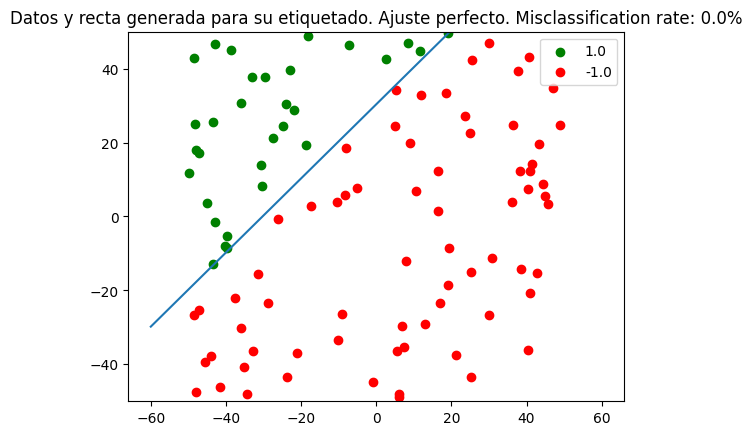

In [41]:
#Intervalo donde queremos los puntos
intervalo = [-50,50]

#Obtención de la recta del intervalo
a, b = simula_recta(intervalo)

#Generacion de los puntos
puntos = simula_unif(100,2,intervalo)
x = puntos.copy()



#Obtención de las etiquetas de los puntos generados con respecto a la recta generada
y = []
for elem in x:
  y.append(f(elem[0], elem[1], a, b))
y = np.array(y)

print("Misclasification rate: " + str(miss_rate(x,y,a,b)) + "%")

plot1 = x[np.where(y==1)]
plt.scatter(plot1[:,0], plot1[:,1], color="green", label = 1.0)
plot_minus1 = x[np.where(y==-1)]
plt.scatter(plot_minus1[:,0], plot_minus1[:,1], color="red", label = -1.0)

x1 = np.linspace(-60,60,2)
y1 = (a*x1 + b)
plt.plot(x1,y1)

plt.ylim(-50,50)
plt.title("Datos y recta generada para su etiquetado. Ajuste perfecto. Misclassification rate: " + str(str(miss_rate(x,y,a,b))) + "%")
plt.legend(loc="upper right")
plt.show()


Tras generar una recta de forma aleatoria y una nube de puntos con los requerimientos del enunciado, se puede observar que, todos están bien clasificados. Esa recta es una frontera dentro de la nube de puntos. Dado el componente aleatorio, en cada ejecución puede cambiar, pero al estar fijada una semilla, la primera ejecución siempre mostrará esta nube de puntos con esta recta, con objetivo de garantizar la reproducibilidad de la práctica.

#### <font color='blue'>b) (0.5 puntos)  Introducción de ruido. 
Modifique de forma aleatoria un 10\% de las etiquetas positivas y otro
10\% de las negativas y guarde los puntos con sus nuevas etiquetas. Dibuje de nuevo
la gráfica anterior. Ahora habrá puntos mal clasificados respecto de la recta.</font>


Misclasification rate: 10.0%


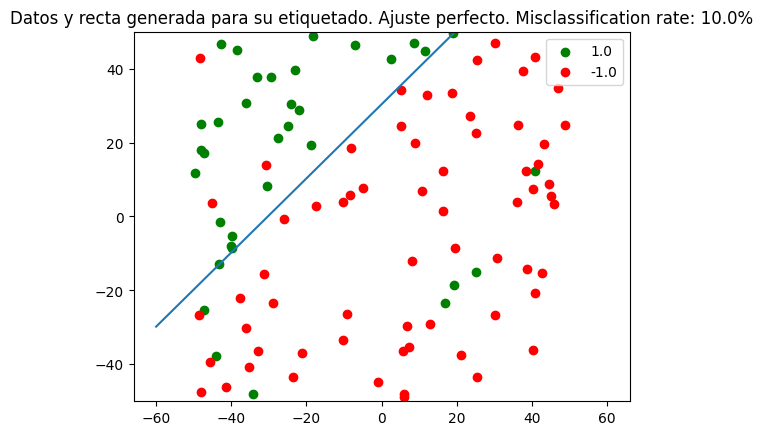

In [42]:
#Se obtiene una y con ruido y se repite el proceso anterior, la tasa de fallo ya no es 0
y_ruido = introducir_ruido(y,10)

print("Misclasification rate: " + str(miss_rate(x,y_ruido,a,b)) + "%")

plot1 = x[np.where(y_ruido==1)]
plt.scatter(plot1[:,0], plot1[:,1], color="green", label = 1.0)
plot_minus1 = x[np.where(y_ruido==-1)]
plt.scatter(plot_minus1[:,0], plot_minus1[:,1], color="red", label = -1.0)

x1 = np.linspace(-60,60,2)
y1 = (a*x1 + b)
plt.plot(x1,y1)

plt.ylim(-50,50)
plt.title("Datos y recta generada para su etiquetado. Ajuste perfecto. Misclassification rate: " + str(str(miss_rate(x,y_ruido,a,b))) + "%")
plt.legend(loc="upper right")
plt.show()



En cuanto a la introducción de ruido (es decir, puntos que por algún motivo u otro están mal clasificados), se realiza con un método. Podríamos pensar que seleccionando un 10% de cada clase y cambiando su etiqueta a la contraria ya está solucionado. El problema es, por ejemplo, si mi clase 1 tiene 32 puntos y mi clase -1 tiene 68, claramente no se pueden cambiar 3.2 puntos de la primera clase y 6.8 de la segunda. Este comportamiento se tiene en cuenta  redondeando los puntos a cambiar (es decir, se cambiarían 3 de la primera y 7 de la segunda).

Claramente, la obtención de unos datos etiquetados sin ruido y otros es para, con los sucesivos ejercicios que restan, observar las diferencias de ciertos algoritmos de clasificación, cuando las etiquetas no tienen ruido y están clasificadas perfectamente (un escenario ideal y que poco se da en los casos reales de aprendizaje), y las etiquetas con ruido (lo normal en el día a día, con lo que siempre hay que lidiar).

#### <font color='blue'>c) (2.5 puntos)  Análisis y comparación de distintas fronteras de decisión. 
Supongamos ahora que las siguientes funciones definen la frontera de
clasificación de los puntos de la muestra en lugar de una recta.</font>

<font color='blue'>$f_1(x, y) = (x - 10)^2 + (y - 20)^2 - 400$</font>

<font color='blue'>$f_2(x, y) = 0.5(x + 10)^2 + (y - 20)^2 - 400$</font>

<font color='blue'>$f_3(x, y) = 0.5(x - 10)^2 - (y + 20)^2 - 400$</font>

<font color='blue'>$f_4(x, y) = y - 20x^2 - 5x + 3$</font>


<font color='blue'>

Visualizar el etiquetado generado en el Apartado (b) junto con la gráfica de cada
una de las funciones. Muéstrense los porcentajes de acierto en clasificación para las funciones (es decir, fronteras de decisión) evaluadas. Argumente si estas funciones más
complejas son mejores clasificadores que la función lineal. Observe las gráficas y diga
qué consecuencias extrae sobre la influencia de la modificación de etiquetas
en el proceso de aprendizaje. En concreto, razone sobre cuestiones como las siguientes: ¿Necesariamente funciones más complejas son mejores clasificadores (es decir, representan “mejores” bordes de decisión)? ¿Es posible superar/mejorar ese 10% de error de clasificación? ¿Qué pasa si repetimos el proceso con estas funciones más complejas (las empleamos para etiquetar los datos y luego metemos un 10% de ruido)? ¿Qué error de clasificación tenemos? ¿Es menor que ese 10%?
</font>



In [43]:
"""
Esta función permite visualizar las fronteras de decisión.

Entradas: 
- X: datos de entrada con tantas filas como ejemplos, y tantas columnas como dimensiones/features
- y: etiquetas
- fz: función que define la frontera de decisión
- title: título que se le quiere poner a la figura
- xaxis: nombre que se le quiere poner al eje X
- yaxis: nombre que se le quiere poner al eje Y

Salida: visualización de los datos junto con la frontera de decisión proporcionada

Ejemplo de uso: 
def f_prueba(X):
	return X[:,0]**2 + X[:,1]**2 - 200
plot_datos_cuad(X, y, f_prueba, title=r'$f_{prueba}(x, y) = x^2 + y^2 - 200$')
"""
def plot_datos_cuad(X, y, fz, title='Point cloud plot', xaxis='x axis', yaxis='y axis'):
    #Preparar datos
    min_xy = X.min(axis=0)
    max_xy = X.max(axis=0)
    border_xy = (max_xy-min_xy)*0.01
    
    #Generar grid de predicciones
    # np.mgrid es una versión multidimensional de meshgrid (https://numpy.org/doc/stable/reference/generated/numpy.mgrid.html)
    xx, yy = np.mgrid[min_xy[0]-border_xy[0]:max_xy[0]+border_xy[0]+0.001:border_xy[0], 
                      min_xy[1]-border_xy[1]:max_xy[1]+border_xy[1]+0.001:border_xy[1]]
    # np.ravel "aplana" un array (https://numpy.org/doc/stable/reference/generated/numpy.ravel.html)
    # Diferencias entre ravel y flatten: https://stackoverflow.com/questions/28930465/what-is-the-difference-between-flatten-and-ravel-functions-in-numpy
    # np.c_ permite concatenar arrays a lo largo del segundo eje (https://numpy.org/doc/stable/reference/generated/numpy.c_.html)
    grid = np.c_[xx.ravel(), yy.ravel(), np.ones_like(xx).ravel()]
    pred_y = np.sign(fz(grid)).reshape(xx.shape)
    
    #Plot
    f, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(xx, yy, pred_y, 50, cmap='RdBu',vmin=-1, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label('$f(x, y)$')
    ax_c.set_ticks([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, linewidth=1, 
                cmap="RdYlBu", edgecolor='white')
    
    XX, YY = np.meshgrid(np.linspace(round(min(min_xy)), round(max(max_xy)),X.shape[0]),np.linspace(round(min(min_xy)), round(max(max_xy)),X.shape[0]))
    positions = np.vstack([XX.ravel(), YY.ravel()])
    # ax.contour(XX,YY,fz(positions.T).reshape(X.shape[0],X.shape[0]),[0], colors='white')
    
    ax.set(
       xlim=(min_xy[0]-border_xy[0], max_xy[0]+border_xy[0]), 
       ylim=(min_xy[1]-border_xy[1], max_xy[1]+border_xy[1]),
       xlabel=xaxis, ylabel=yaxis)
    plt.title(title)
    plt.show()

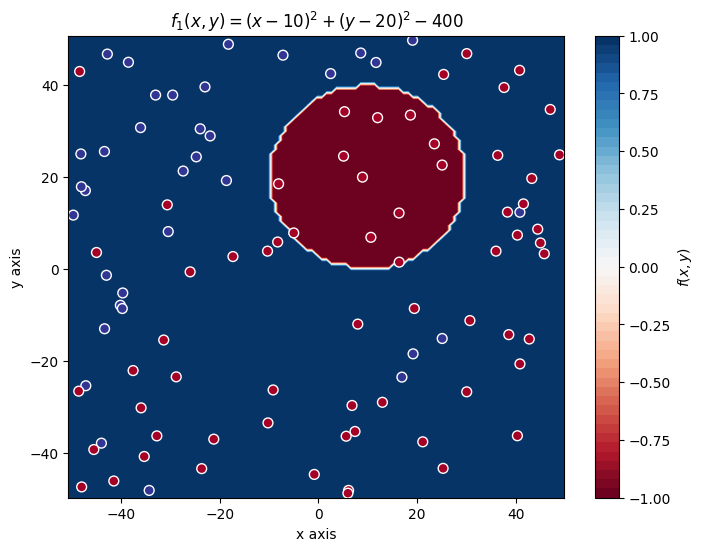

Misclassification rate: 53.0%


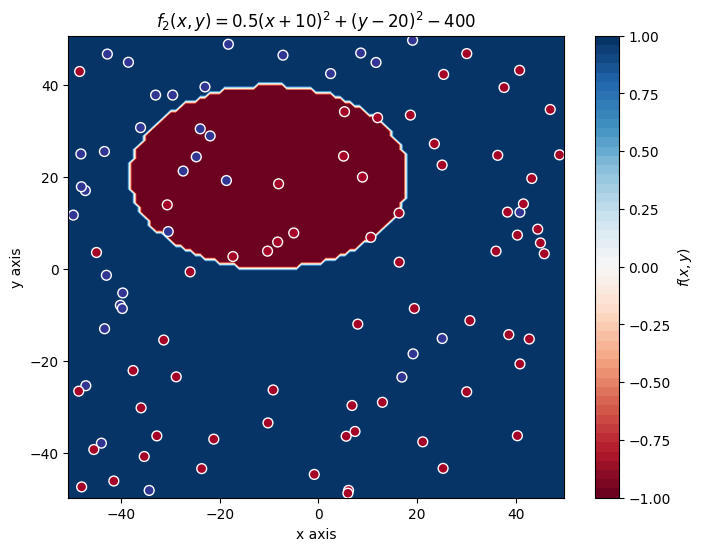

Misclassification rate: 61.0%


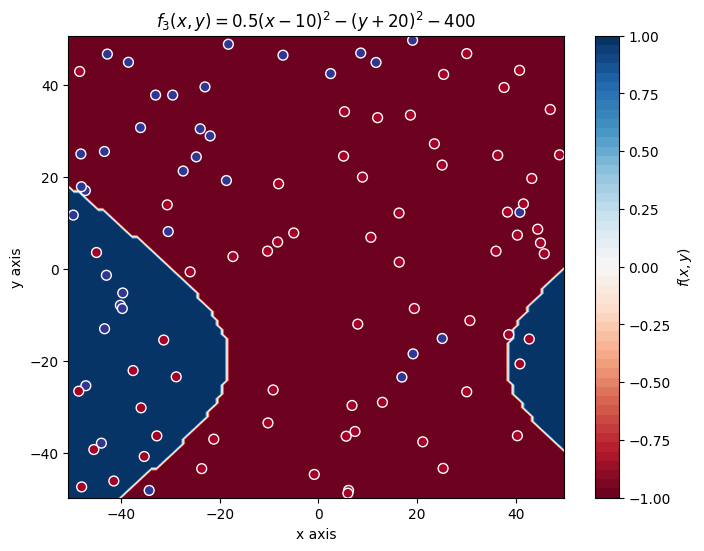

Misclassification rate: 40.0%


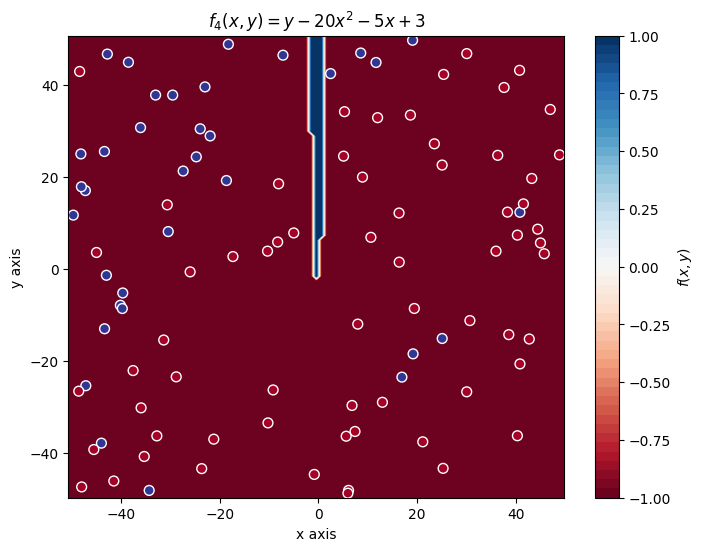

Misclassification rate: 35.0%


In [44]:
#Esto es otra función propia de tasa de fallo para este ejercicio, ya que se pide la función que se usa como frontera y 
#se calculan las etiquetas predichas con el signo del valor de esta función aplicado al vector de características X
def miss_rate2(X,y,funcion):
  sign = np.vectorize(signo)
  y_pred = np.array(sign(funcion(X)))
  comparativa = y_pred == y #Esto devuelve un array de booleanos donde False indica que y_pred e y son diferentes
  cantidad_fallada = len(np.where(comparativa==False)[0]) #Asi que se cuentan las posiciones con False, que son las falladas
  return cantidad_fallada/len(y)*100

#Para este ejercicio se cuenta con una función de visualizado que lo hace todo por nosotros, ya que pasandole los vectores de características
#y las etiquetas que suponemos verdaderas (las que se generan con la recta aleatoria), además de la función que suponemos la frontera de clasificación, 
#ya se proporciona un dibujo.
def f_primera(X):
	return (X[:,0]-10)**2 + (X[:,1]-20)**2 - 400
def f_segunda(X):
  return 0.5*(X[:,0]+10)**2 + (X[:,1] - 20)**2-400
def f_tercera(X):
  return 0.5*(X[:,0]-10)**2 - (X[:,1]+20)**2 - 400
def f_cuarta(X):
  return X[:,1] - 20*X[:,0]**2 - 5* X[:,0] + 3
plot_datos_cuad(x, y_ruido, f_primera, title=r'$f_{1}(x, y) = (x-10)^2 + (y-20)^2 - 400$')
print('Misclassification rate: {}%'.format(miss_rate2(x,y_ruido,f_primera)))
plot_datos_cuad(x, y_ruido, f_segunda, title=r'$f_{2}(x, y) = 0.5(x + 10)^2 +  (y - 20)^2 - 400$')
print('Misclassification rate: {}%'.format(miss_rate2(x,y_ruido,f_segunda)))
plot_datos_cuad(x, y_ruido, f_tercera, title=r'$f_{3}(x, y) = 0.5(x - 10)^2 -  (y + 20)^2 - 400$')
print('Misclassification rate: {}%'.format(miss_rate2(x,y_ruido,f_tercera)))
plot_datos_cuad(x, y_ruido, f_cuarta, title=r'$f_{4}(x, y) = y - 20x^2 - 5x + 3$')
print('Misclassification rate: {}%'.format(miss_rate2(x,y_ruido,f_cuarta)))

Las funciones más complejas pueden clasificar mejor una muestra de datos concreta pero suelen ser peores a la hora de generalizar, precisamente por el ruido presente casi siempre en todos los conjuntos de datos. 
¿Se podría haber bajado el porcentaje de clasificación? Partiendo de que, simplemente, estamos probando a clasificar los datos con funciones más complejas que una recta, habría que dar con una función que teniendo en cuenta el ruido y la distribución de los datos para esta muestra, acierte más que la recta. No obstante, esto no deja de ser una tarea de ensayo y error, sin entrenamiento previo y que no garantiza nada al enfrentarnos con la misma función a otra muestra distinta.

Como se observa en los resultados anteriores, ninguna función a conseguido más acierto que la recta.

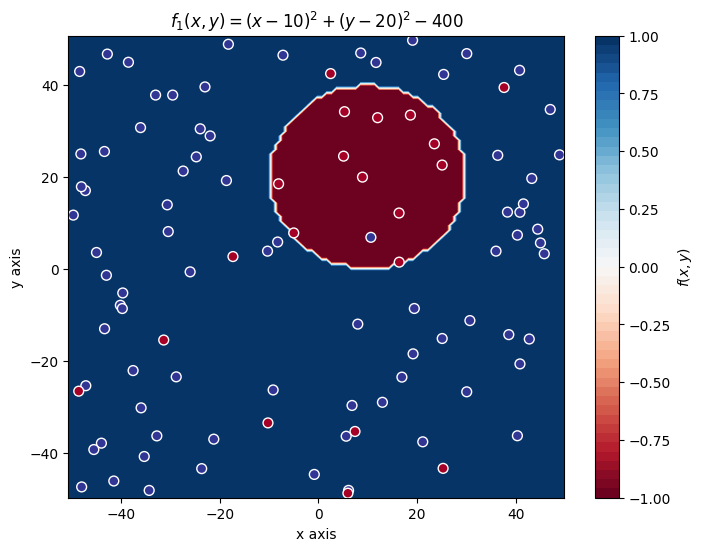

Misclassification rate: 10.0%


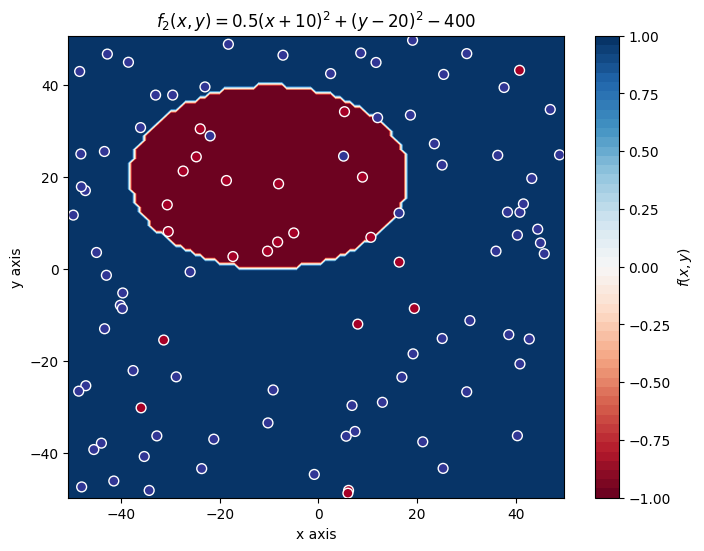

Misclassification rate: 10.0%


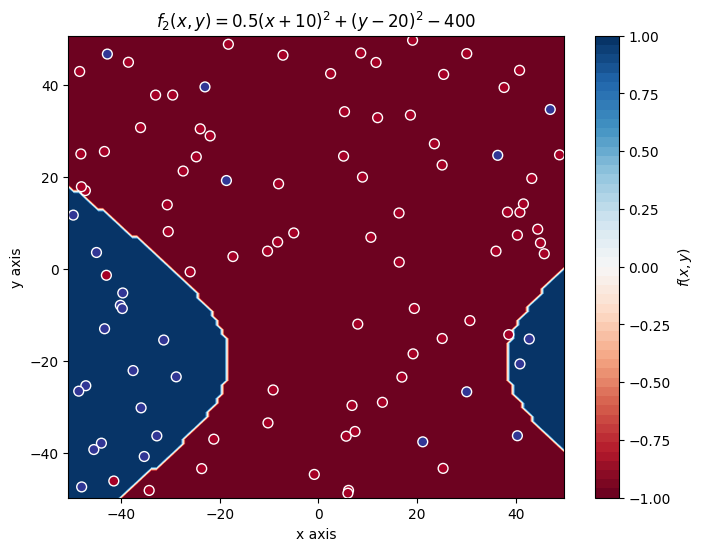

Misclassification rate: 10.0%


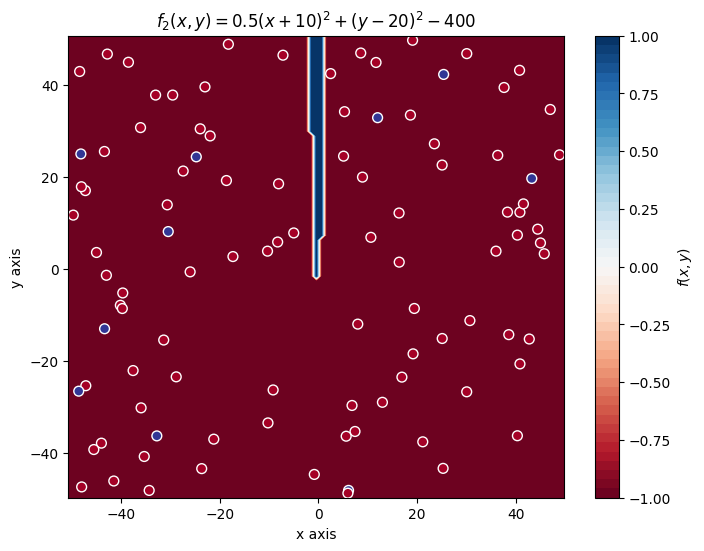

Misclassification rate: 10.0%


In [45]:
sign = np.vectorize(signo)

y_p = sign(f_primera(x))
y_p = introducir_ruido(y_p, 10)
plot_datos_cuad(x, y_p, f_primera, title=r'$f_{1}(x, y) = (x-10)^2 + (y-20)^2 - 400$')
print('Misclassification rate: {}%'.format(miss_rate2(x,y_p,f_primera)))

y_p = sign(f_segunda(x))
y_p = introducir_ruido(y_p, 10)
plot_datos_cuad(x, y_p, f_segunda, title=r'$f_{2}(x, y) = 0.5(x + 10)^2 +  (y - 20)^2 - 400$')
print('Misclassification rate: {}%'.format(miss_rate2(x,y_p,f_segunda)))

y_p = sign(f_tercera(x))
y_p = introducir_ruido(y_p, 10)
plot_datos_cuad(x, y_p, f_tercera, title=r'$f_{2}(x, y) = 0.5(x + 10)^2 +  (y - 20)^2 - 400$')
print('Misclassification rate: {}%'.format(miss_rate2(x,y_p,f_tercera)))

y_p = sign(f_cuarta(x))
y_p = introducir_ruido(y_p, 10)
plot_datos_cuad(x, y_p, f_cuarta, title=r'$f_{2}(x, y) = 0.5(x + 10)^2 +  (y - 20)^2 - 400$')
print('Misclassification rate: {}%'.format(miss_rate2(x,y_p,f_cuarta)))

Si empleamos las funciones para clasificar y luego se introduce el ruido, tendremos un porcentaje de error igual al ruido introducido, tal y como ocurre en las ejecuciones anteriores. Parecía lógico pensar esto a priori, ya que estamos preparando todo para obtener ese porcentaje de clasificación.

## <font color='blue'>Ejercicio 2: MODELOS LINEALES (8 puntos) </font>

### <font color='blue'>Apartado 2.1 (3 puntos) Algoritmo Perceptrón (PLA). 

<font color='blue'>Implementar la función $ajusta\_PLA(datos, label, max\_iter, vini)$ que calcula el hiperplano solución a un problema de clasificación binaria usando el algoritmo PLA. La entrada $datos$ es una matriz donde cada ejemplo está representado por una fila de la matriz, $label$ el vector de etiquetas (cada etiqueta es
un valor +1 o -1), $max\_iter$ es el número máximo de iteraciones permitidas y $vini$
el valor inicial del vector. La función devuelve, como mínimo, los coeficientes del hiperplano y la iteración de convergencia.  </font>



In [46]:
#Esta es la función para obtener un hiperplano solución con Perceptron para un conjunto de datos
#Como se puede observar, hay 2 versiones, 1 si max_iter es negativo y otra si no lo es
#En caso de que sea negativo el unico criterio de parada es que no se realice ningún cambio de w en un recorrido completo de los datos
#Si no es negativo, además de este criterio se tiene en cuenta que las iteraciones no superen el máximo proporcionado
#Ambos siguen el algoritmo PLA, si la w no predice bien la etiqueta de un cierto x, se actualiza, y así bien hasta realizar una pasada por todos los datos sin actualizar w
#o hasta agotar el número máximo de iteraciones
def ajusta_PLA(datos, label, max_iter, vini):
    w = vini.copy()
    x = datos.copy()
    y = label.copy()
    no_cambios = False
    it = 0
    mal_its = 0
    if(max_iter < 0):
      while(no_cambios == False):
        no_cambios = True
        for i in range(len(y)):
          carac = x[i]
          l = y[i]
          
          if (signo(w.T@carac) != l):
            mal_its += 1
            w = w + l * carac
            w_prueba = w.copy()
            primera = False
            no_cambios = False
          it += 1
      print("Actualizaciones de w")
      print(mal_its)
    else:
      while(no_cambios == False):
        no_cambios = True
        
        for i in range(len(y)):
          carac = x[i]
          l = y[i]
           
          if (signo(w.T@carac) != l and it < max_iter):
            mal_its += 1
            w = w + l * carac
            no_cambios = False
          
          elif(it >= max_iter):
            return w, it
          it += 1
          
          
          


    return w, it
        


<font color='blue'>Ejecutar el algoritmo PLA con los datos empleados en el Apartado (a) del Ejercicio 1. Inicializar el algoritmo con: 

<font color='blue'>i) el vector cero y, 

<font color='blue'>ii) con vectores de
números aleatorios en [0, 1] (10 veces). 

<font color='blue'>Anotar el número medio de iteraciones
necesarias en ambos para converger. Se deben mostrar en una tabla cada uno de los pesos iniciales empleados, los finales (obtenidos tras el proceso de entrenamiento), y el porcentaje de error de clasificación. También se debe visualizar una nube de puntos etiquetada junto con la frontera resultante del ajuste. Valorar el resultado relacionando el punto
de inicio con el número de iteraciones. </font>

In [47]:
#Nuevo método para mostrar la tasa de fallo, esta vez se pasan los vectores de características, las etiquetas, y un vector de pesos 
#con el que se va a predecir.
def miss_rate3(X,y,w):
  y_pred = []
  for x in X:
    y_pred.append(signo(w.T@x))
  y_pred = np.array(y_pred)
  comparativa = y_pred == y #Esto devuelve un array de booleanos donde False indica que y_pred e y son diferentes
  cantidad_fallada = len(np.where(comparativa==False)[0]) #Asi que se cuentan las posiciones con False, que son las falladas
  return cantidad_fallada/len(y)*100

Actualizaciones de w
799
Actualizaciones de w
3691
Actualizaciones de w
1107
Actualizaciones de w
1921
Actualizaciones de w
2395
Actualizaciones de w
2472
Actualizaciones de w
2253
Actualizaciones de w
2538
Actualizaciones de w
2498
Actualizaciones de w
2109
Actualizaciones de w
896
TABLA RESULTADOS
+---------------+------------------------------------+------------------------------------------------+-----------------+
|   ITERACIONES | INICIAL                            | FINAL                                          |   MIS. RATE (%) |
+===============+====================================+================================================+=================+
|          3400 | [0. 0. 0.]                         | [-587.          -19.50154253   19.79007314]    |               0 |
+---------------+------------------------------------+------------------------------------------------+-----------------+
|         31600 | [0.87021266 0.13963125 0.01807095] | [-1630.12978734   -57.66141634    

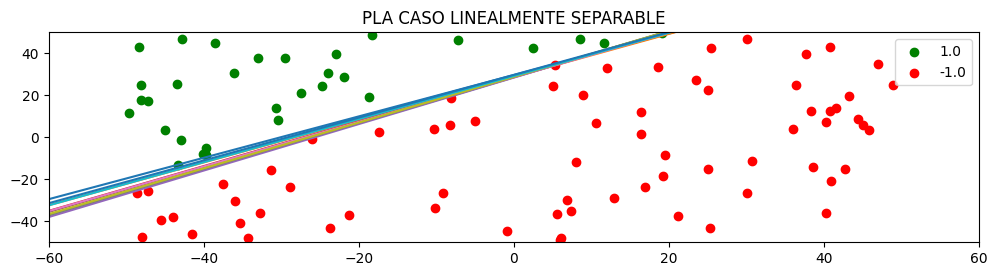

In [48]:
from tabulate import tabulate
#Este método imprime un gráfico con los datos etiquetados y separados por tantas líneas
#como vectores de pesos haya en ws
def impresion(x,y,ws, titulo):
  fig = plt.figure(figsize=(12,6))
  ax1 = fig.add_subplot(211)
  plot1 = x[np.where(y==1)]
  ax1.scatter(plot1[:,1], plot1[:,2], color="green", label = 1.0)
  plot_minus1 = x[np.where(y==-1)]
  ax1.scatter(plot_minus1[:,1], plot_minus1[:,2], color="red", label = -1.0)

  for w in ws:
    x1 = np.linspace(-60,60,2)
    y1 = ((w[0]+w[1]*x1)/-w[2])
    ax1.plot(x1,y1)

  ax1.set_ylim(-50,50)
  ax1.set_xlim(-60,60)
  ax1.set_title(titulo)
  ax1.legend(loc="upper right")

  plt.show()
def impresion2(x,y,w, titulo):
  fig = plt.figure(figsize=(6,8))
  ax1 = fig.add_subplot(211)
  plot1 = x[np.where(y==1)]
  ax1.scatter(plot1[:,1], plot1[:,2], color="green", label = 1.0)
  plot_minus1 = x[np.where(y==-1)]
  ax1.scatter(plot_minus1[:,1], plot_minus1[:,2], color="red", label = -1.0)

  x1 = np.linspace(-60,60,2)
  y1 = ((w[0]+w[1]*x1)/-w[2])
  ax1.plot(x1,y1)
  ax1.set_ylim(-50,50)
  ax1.set_xlim(-60,60)
  ax1.set_title(titulo)
  ax1.legend(loc="upper right")

  plt.show()

#Para los primeros ejercicios no se necesitaba una columna entera de 1's en X, pero ahora sí, para aplicar PLA.
x = np.insert(x, 0, 1, axis=1)

#np.random.seed(33)
ws_aleatorios = []

#Variables para usar tabulate
dic_tabla_1 = {}
iters =[]
iniciales = []
finales = []
miss_rate = []

#Primer experimento
vector1 = np.zeros(x.shape[1])
# vector2 = np.random.uniform(0,1, size=x.shape[1])
# vector3 = np.random.uniform(0,1, size=x.shape[1])
# vector4 = np.random.uniform(0,1, size=x.shape[1])

w1, it1 = ajusta_PLA(x, y, -1 , vector1)
iters.append(it1)
finales.append(w1)
iniciales.append(vector1)
miss_rate.append(miss_rate3(x,y,w1))

# w2, it2 = ajusta_PLA(x, y, -1 , vector2)
# iters.append(it2)
# finales.append(w2)
# iniciales.append(vector2)
# miss_rate.append(miss_rate3(x,y,w2))

#Los 10 experimentos con vectores de pesos aleatorios
for i in range(10):
  vector2 = np.random.uniform(0,1, size=x.shape[1])
  w2, it2  = ajusta_PLA(x, y, -1 , vector2)
  ws_aleatorios.append(w2)
  iters.append(it2)
  finales.append(w2)
  iniciales.append(vector2)
  miss_rate.append(miss_rate3(x,y,w2))

# w3, it3 = ajusta_PLA(x, y, -1 , vector3)
# iters.append(it3)
# finales.append(w3)
# iniciales.append(vector3)
# miss_rate.append(miss_rate3(x,y,w3))

# w4, it4 = ajusta_PLA(x, y, -1 , vector4)
# iters.append(it4)
# finales.append(w4)
# iniciales.append(vector4)
# miss_rate.append(miss_rate3(x,y,w4))

#Se imprime la tabla con tabulate y el diccionario con todos los resultados
print("TABLA RESULTADOS")
dic_tabla_1["ITERACIONES"] = iters
dic_tabla_1["INICIAL"] = iniciales
dic_tabla_1["FINAL"] = finales
dic_tabla_1["MIS. RATE (%)"] = miss_rate
print(tabulate(dic_tabla_1, headers=dic_tabla_1.keys(), tablefmt = "grid"))
# a = w[0]
# b = w[1]

# print("Misclasification rate: " + str(miss_rate(x,y,a,b)) + "%")

# w, it = ajusta_PLA(x, y, 250000 ,np.random.uniform(0,1, size=x.shape[1]))
# a = w[0]
# b = w[1]
# print(w, it)
# print("Misclasification rate: " + str(miss_rate(x,y,a,b)) + "%")

# plt.figure(figsize=(12,6))

# plot1 = x[np.where(y==1)]
# plt.scatter(plot1[:,1], plot1[:,2], color="green", label = 1.0)
# plot_minus1 = x[np.where(y==-1)]
# plt.scatter(plot_minus1[:,1], plot_minus1[:,2], color="red", label = -1.0)

# x1 = np.linspace(-60,80,2)
# y1 = ((w1[0]+w1[1]*x1)/-w1[2])
# y2 = ((w2[0]+w2[1]*x1)/-w2[2])
# y3 = ((w3[0]+w3[1]*x1)/-w3[2])
# y4 = ((w4[0]+w4[1]*x1)/-w4[2])

# plt.plot(x1,y1, color="red")
# plt.plot(x1,y2, color="blue")
# plt.plot(x1,y3, color="green")
# plt.plot(x1,y4, color="purple")

# plt.ylim(-50,50)
# plt.xlim(-60,60)
# # plt.title("Datos y recta generada para su etiquetado. Ajuste perfecto. Misclassification rate: " + str(str(miss_rate(x,y_ruido,a,b))) + "%")
# plt.legend(loc="upper right")

# plt.show()
#Se imprime con el método que se cuenta al principio todas las líneas calculadas por perceptron
w1 = np.array([w1])
ws_aleatorios = np.array(ws_aleatorios)
ws = np.concatenate((w1, np.array(ws_aleatorios)))

impresion(x,y,ws,"PLA CASO LINEALMENTE SEPARABLE")


Al ser los datos linealmente separables, se sabe que PLA encontrará en tiempo finito un hiperplano solución para los datos. Por tanto, para la realización de este ejercicio, a PLA se le pasa -1 como número máximo de iteraciones y ya internamente lo trata como que no hay limite de iteraciones y tiene que ejecutarse hasta converger.

Como cada vez que se recorre un vector de características se suma 1 iteración, en el número de iteraciones de la tabla se incluyen las del último recorrido que se hace a todos los datos y que sirve para determinar que w no cambia en ninguna iteración de ese recorrido, por lo que, al tener 100 datos, realmente la w que se muestra se encuentra 100 iteraciones antes de las que salen en la tabla.

En cuanto al punto de inicio y las iteraciones necesarias para converger, en base a los resultados, se puede afirmar, como era lógico pensar, que mientras más iteraciones se necesiten para converger, más actualizaciones de la w se producirán en cada época (una lectura completa de los datos).

Justo antes de la tabla, se ha impreso las veces que w se actualiza en PLA. Hay que tener en cuenta que, cuando se actualiza la w, se está clasificando bien el punto que se tiene entre manos, lo que no evita que se puedan clasificar mal otros que estaban bien clasificados. La única relación que se puede encontrar entre el punto inicial y las iteraciones necesarias para converger es que, los puntos que necesitan menos iteraciones para converger, evitan este comportamiento en mayor medida que los demás, y, por consiguiente, tienen que hacer menos actualizaciones en total de la w.

No obstante, esto es un resultado experimental para esos puntos de inicio concretos, por lo que no se puede afirmar que si nos encontramos ante unos datos linealmente separables, el vector 0 sea el mejor punto de inicio, si no que es el punto que menos iteraciones ha realizado para este experimento concreto.

Lo mejor, entonces, para elegir el punto de inicio, es realizar diversas ejecuciones con diferentes puntos de inicio y seleccionar la mejor, la que menos tiempo tarde en converger.

Actualizaciones de w
799
Actualizaciones de w
2996
Actualizaciones de w
1885
Actualizaciones de w
2096
Actualizaciones de w
764
Actualizaciones de w
1050
Actualizaciones de w
808
Actualizaciones de w
1875
Actualizaciones de w
2923
Actualizaciones de w
1857
Actualizaciones de w
1982
Actualizaciones de w
2279
Actualizaciones de w
600
Actualizaciones de w
2804
Actualizaciones de w
3082
Actualizaciones de w
3051
Actualizaciones de w
2980
Actualizaciones de w
801
Actualizaciones de w
2388
Actualizaciones de w
3045
Actualizaciones de w
2098
Actualizaciones de w
692
Actualizaciones de w
759
Actualizaciones de w
2122
Actualizaciones de w
1090
Actualizaciones de w
1892
Actualizaciones de w
805
Actualizaciones de w
2530
Actualizaciones de w
914
Actualizaciones de w
796
Actualizaciones de w
1866
Actualizaciones de w
2125
Actualizaciones de w
2969
Actualizaciones de w
1922
Actualizaciones de w
2063
Actualizaciones de w
1725
Actualizaciones de w
988
Actualizaciones de w
1846
Actualizaciones de w
18

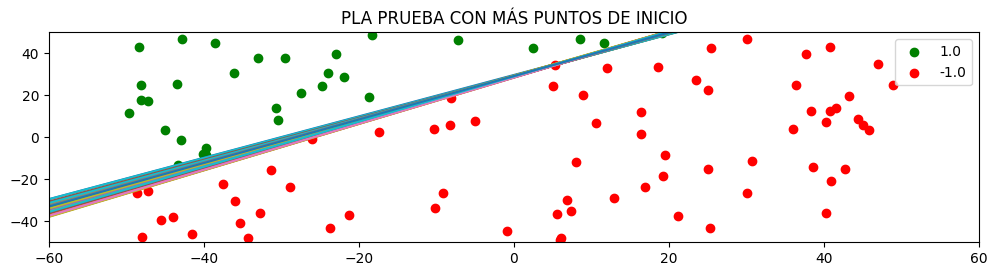

In [49]:
ws_aleatorios = []

#Variables para usar tabulate
dic_tabla_1 = {}
iters =[]
iniciales = []
finales = []
miss_rate = []

#Primer experimento
vector1 = np.zeros(x.shape[1])
# vector2 = np.random.uniform(0,1, size=x.shape[1])
# vector3 = np.random.uniform(0,1, size=x.shape[1])
# vector4 = np.random.uniform(0,1, size=x.shape[1])

w1, it1 = ajusta_PLA(x, y, -1 , vector1)
iters.append(it1)
finales.append(w1)
iniciales.append(vector1)
miss_rate.append(miss_rate3(x,y,w1))

# w2, it2 = ajusta_PLA(x, y, -1 , vector2)
# iters.append(it2)
# finales.append(w2)
# iniciales.append(vector2)
# miss_rate.append(miss_rate3(x,y,w2))

#Los 10 experimentos con vectores de pesos aleatorios
for i in range(50):
  vector2 = np.random.uniform(0,1, size=x.shape[1])
  w2, it2  = ajusta_PLA(x, y, -1 , vector2)
  ws_aleatorios.append(w2)
  iters.append(it2)
  finales.append(w2)
  iniciales.append(vector2)
  miss_rate.append(miss_rate3(x,y,w2))

# w3, it3 = ajusta_PLA(x, y, -1 , vector3)
# iters.append(it3)
# finales.append(w3)
# iniciales.append(vector3)
# miss_rate.append(miss_rate3(x,y,w3))

# w4, it4 = ajusta_PLA(x, y, -1 , vector4)
# iters.append(it4)
# finales.append(w4)
# iniciales.append(vector4)
# miss_rate.append(miss_rate3(x,y,w4))

#Se imprime la tabla con tabulate y el diccionario con todos los resultados
print("TABLA RESULTADOS")
dic_tabla_1["ITERACIONES"] = iters
dic_tabla_1["INICIAL"] = iniciales
dic_tabla_1["FINAL"] = finales
dic_tabla_1["MIS. RATE (%)"] = miss_rate
print(tabulate(dic_tabla_1, headers=dic_tabla_1.keys(), tablefmt = "grid"))
# a = w[0]
# b = w[1]

# print("Misclasification rate: " + str(miss_rate(x,y,a,b)) + "%")

# w, it = ajusta_PLA(x, y, 250000 ,np.random.uniform(0,1, size=x.shape[1]))
# a = w[0]
# b = w[1]
# print(w, it)
# print("Misclasification rate: " + str(miss_rate(x,y,a,b)) + "%")

# plt.figure(figsize=(12,6))

# plot1 = x[np.where(y==1)]
# plt.scatter(plot1[:,1], plot1[:,2], color="green", label = 1.0)
# plot_minus1 = x[np.where(y==-1)]
# plt.scatter(plot_minus1[:,1], plot_minus1[:,2], color="red", label = -1.0)

# x1 = np.linspace(-60,80,2)
# y1 = ((w1[0]+w1[1]*x1)/-w1[2])
# y2 = ((w2[0]+w2[1]*x1)/-w2[2])
# y3 = ((w3[0]+w3[1]*x1)/-w3[2])
# y4 = ((w4[0]+w4[1]*x1)/-w4[2])

# plt.plot(x1,y1, color="red")
# plt.plot(x1,y2, color="blue")
# plt.plot(x1,y3, color="green")
# plt.plot(x1,y4, color="purple")

# plt.ylim(-50,50)
# plt.xlim(-60,60)
# # plt.title("Datos y recta generada para su etiquetado. Ajuste perfecto. Misclassification rate: " + str(str(miss_rate(x,y_ruido,a,b))) + "%")
# plt.legend(loc="upper right")

# plt.show()
#Se imprime con el método que se cuenta al principio todas las líneas calculadas por perceptron
w1 = np.array([w1])
ws_aleatorios = np.array(ws_aleatorios)
ws = np.concatenate((w1, np.array(ws_aleatorios)))

impresion(x,y,ws,"PLA PRUEBA CON MÁS PUNTOS DE INICIO")

En esta tabla se puede observar lo comentado anteriormente, hay un nuevo punto de inicio que tarda menos en converger que el vector 0, que era el mejor del experimento que se pedía.

Por tanto, se puede determinar, que la relación entre el punto de inicio y las iteraciones para converger es algo que se puede determinar tras ejecutar PLA y comprobar como se maneja con el conjunto de datos concreto que se use.

<font color='blue'>Ahora, hay que hacer lo mismo usando  los datos del Apartado (b) del Ejercicio 1, y $150.000$ como número máximo de iteraciones. ¿Se observa algún comportamiento diferente? En caso afirmativo, diga cuál y las
razones para que ello ocurra. </font>

TABLA RESULTADOS
+---------------+------------------------------------+---------------------------------------------+-----------------+
|   ITERACIONES | INICIAL                            | FINAL                                       |   MIS. RATE (%) |
+===============+====================================+=============================================+=================+
|        150000 | [0. 0. 0.]                         | [-799.          -31.68952229   30.53168355] |               3 |
+---------------+------------------------------------+---------------------------------------------+-----------------+
|        150000 | [0.96287115 0.56713136 0.94721533] | [-818.03712885  -39.31987628   42.38394781] |               5 |
+---------------+------------------------------------+---------------------------------------------+-----------------+
|        150000 | [0.85692411 0.70349932 0.18011646] | [-802.14307589  -29.47344313   27.13614459] |               1 |
+---------------+--------------

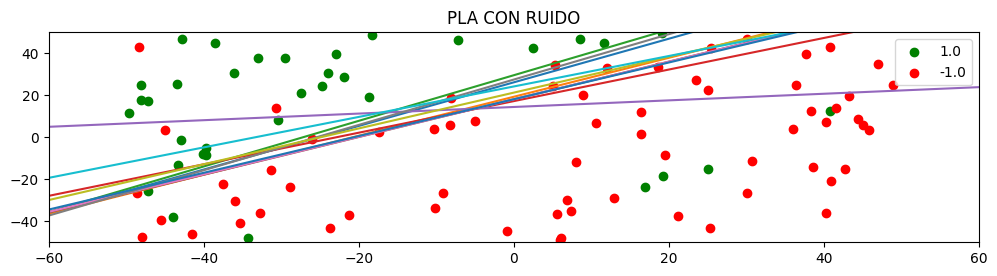

In [50]:
# #En este no va a converger porque los datos no son linealmente separables
# np.random.seed(33)

# dic_tabla_1 = {}
# iters =[]
# iniciales = []
# finales = []
# miss_rate = []

# vector1 = np.zeros(x.shape[1])
# vector2 = np.random.uniform(0,1, size=x.shape[1])
# vector3 = np.random.uniform(0,1, size=x.shape[1])
# vector4 = np.random.uniform(0,1, size=x.shape[1])

# w1, it1 = ajusta_PLA(x, y_ruido, 150000 , vector1)
# iters.append(it1)
# finales.append(w1)
# iniciales.append(vector1)
# miss_rate.append(miss_rate3(x,y_ruido,w1))

# w2, it2 = ajusta_PLA(x, y_ruido, 150000 , vector2)
# iters.append(it2)
# finales.append(w2)
# iniciales.append(vector2)
# miss_rate.append(miss_rate3(x,y_ruido,w2))

# w3, it3 = ajusta_PLA(x, y_ruido, 150000 , vector3)
# iters.append(it3)
# finales.append(w3)
# iniciales.append(vector3)
# miss_rate.append(miss_rate3(x,y_ruido,w3))

# w4, it4 = ajusta_PLA(x, y_ruido, 150000 , vector4)
# iters.append(it4)
# finales.append(w4)
# iniciales.append(vector4)
# miss_rate.append(miss_rate3(x,y_ruido,w4))

# print("TABLA RESULTADOS")
# dic_tabla_1["ITERACIONES"] = iters
# dic_tabla_1["INICIAL"] = iniciales
# dic_tabla_1["FINAL"] = finales
# dic_tabla_1["MIS. RATE (%)"] = miss_rate
# print(tabulate(dic_tabla_1, headers=dic_tabla_1.keys(), tablefmt = "grid"))


# plt.figure(figsize=(12,6))

# plot1 = x[np.where(y_ruido==1)]
# plt.scatter(plot1[:,1], plot1[:,2], color="green", label = 1.0)
# plot_minus1 = x[np.where(y_ruido==-1)]
# plt.scatter(plot_minus1[:,1], plot_minus1[:,2], color="red", label = -1.0)

# x1 = np.linspace(-60,80,2)
# y1 = ((w1[0]+w1[1]*x1)/-w1[2])
# y2 = ((w2[0]+w2[1]*x1)/-w2[2])
# y3 = ((w3[0]+w3[1]*x1)/-w3[2])
# y4 = ((w4[0]+w4[1]*x1)/-w4[2])

# plt.plot(x1,y1, color="red")
# plt.plot(x1,y2, color="blue")
# plt.plot(x1,y3, color="green")
# plt.plot(x1,y4, color="purple")


# plt.ylim(-50,50)
# plt.xlim(-60,60)
# # plt.title("Datos y recta generada para su etiquetado. Ajuste perfecto. Misclassification rate: " + str(str(miss_rate(x,y_ruido,a,b))) + "%")
# plt.legend(loc="upper right")

# plt.show()

#En este ejercicio se hace exactamente lo mismo que antes pero ahora PLA tiene un número máximo de iteraciones
#y las etiquetas tienen ruido en cada clase
ws_aleatorios = []

#Variables para usar tabulate
dic_tabla_1 = {}
iters =[]
iniciales = []
finales = []
miss_rate = []

#Primer experimento
vector1 = np.zeros(x.shape[1])
# vector2 = np.random.uniform(0,1, size=x.shape[1])
# vector3 = np.random.uniform(0,1, size=x.shape[1])
# vector4 = np.random.uniform(0,1, size=x.shape[1])

w1, it1 = ajusta_PLA(x, y_ruido, 150000 , vector1)
iters.append(it1)
finales.append(w1)
iniciales.append(vector1)
miss_rate.append(miss_rate3(x,y,w1))

# w2, it2 = ajusta_PLA(x, y, -1 , vector2)
# iters.append(it2)
# finales.append(w2)
# iniciales.append(vector2)
# miss_rate.append(miss_rate3(x,y,w2))

#Los 10 experimentos con vectores de pesos aleatorios
for i in range(10):
  vector2 = np.random.uniform(0,1, size=x.shape[1])
  w2, it2 = ajusta_PLA(x, y_ruido, 150000 , vector2)
  ws_aleatorios.append(w2)
  iters.append(it2)
  finales.append(w2)
  iniciales.append(vector2)
  miss_rate.append(miss_rate3(x,y,w2))


#Se imprime la tabla con tabulate y el diccionario con todos los resultados
print("TABLA RESULTADOS")
dic_tabla_1["ITERACIONES"] = iters
dic_tabla_1["INICIAL"] = iniciales
dic_tabla_1["FINAL"] = finales
dic_tabla_1["MIS. RATE (%)"] = miss_rate
print(tabulate(dic_tabla_1, headers=dic_tabla_1.keys(), tablefmt = "grid"))

#Se imprime con el método que se cuenta al principio todas las líneas calculadas por perceptron
w1 = np.array([w1])
ws_aleatorios = np.array(ws_aleatorios)
ws = np.concatenate((w1, np.array(ws_aleatorios)))

impresion(x,y_ruido,ws,"PLA CON RUIDO")

Al introducir ruido, la muestra no es linealmente separable y perceptron nunca terminará ni conseguirá una separación lineal de los datos. Por tanto, ahora no sirve de nada relacionar las iteraciones para converger y el punto inicial.

Tampoco serviría relacionarla con la tasa de fallo final mostrada tras 150000 iteraciones, puesto que esta no tiene por qué ser la mejor que se ha obtenido durante la ejecución.

Es aquí donde entra en juego PLA-POCKET, que guarda en cada iteración el mejor w obtenido. Parece lógico, que ante una muestra con ruido, evitemos PLA, que es algo así como jugar a la lotería y usar PLA-POCKET. A partir de este, podemos determinar que un punto de inicio es mejor que otro en base al mejor error registrado. También hay que tener en cuenta que esto es altamente dependiente del número de iteraciones máximas. Nada nos puede hacer evitar pensar que si se suben más las iteraciones, PLA-POCKET no logre obtener un mejor error del que ya se había obtenido, incluso se puede extender esto a PLA, ya que el error antes de la época final (es decir, la w que tenemos cuando se produce la última actualización), puede cambiar si se sube o se baja el número de iteraciones.


Como conclusión, el uso de PLA para muestras con ruido, no tiene mucho sentido, ganando mucho interés el uso de PLA-POCKET. Cuando la muestra es lienalmente separable, ambos devolverán la misma solución, así que es conveniente usar PLA, que necesita menos esfuerzo de cómputo.

### <font color='blue'>Apartado 2.2 (5 puntos) Regresión Logística (RL). 


<font color='blue'>En este ejercicio emplearemos nuestra propia función
objetivo $f$ y un conjunto de datos $\mathcal{D}$ para ver cómo
funciona regresión logística. Consideraremos $d = 2$ para que los datos sean fácilmente visualizables, y emplearemos $\mathcal{X} = [0, 2] \times [0, 2]$ con
probabilidad uniforme de elegir cada $x \in \mathcal{X}$. Elegir una línea en el plano que pase por
$\mathcal{X}$ como la frontera que separa la región en donde $y$ toma valores +1 y -1. Para ello, seleccionar dos puntos aleatorios de $\mathcal{X}$ y calcular la línea
que pasa por ambos. 

<font color='blue'>Impleméntese RL con Gradiente Descendente Estocástico (SGD) del siguiente modo:

> <font color='blue'>1) Inicializar el vector de pesos con valores 0.

> <font color='blue'>2) Parar el algoritmo cuando $\|w^{(t+1)} - w^{(t)}\| < 0.01$, donde $w(t)$ denota el vector
de pesos al final de la época $t$. Recuérdese que una época es un pase completo a través de los $N$
ejemplos de nuestro conjunto de datos.

> <font color='blue'>3) Aplicar una permutación aleatoria de $\{1, 2,..., N\}$ a los índices de los datos, antes
de usarlos en cada época del algoritmo.

</font>


A continuación, se detallan las expresiones usadas para el error de entropía cruzada y su gradiente, inspirados en los demostrados por Abu-Mostafa:

$E_{in}(w) = \frac{1}{N}\sum_{n=1}^{N}{log(1 + e^{-y_nw^Tx_n})}$

No obstante, con fin de entender mejor qué significa realmente la entropía cruzada, busqué una fórmula alternativa, propuesta por Andrew NG, donde se visualiza mejor la forma en la que un error afecta al coste de este:

$E_{in}(w) = -\frac{1}{N}\sum_{n=1}^{N}{y_nlog(\frac{1}{1+e^{-w^Tx_n}}) + (1-y_n)log(1 - \frac{1}{1+e^{-w^Tx_n}})}$

Notar que para esta expresión, hay que transformar las etiquetas -1 en 0.

Para el descenso de gradiente, se ha usado la derivada que se propone en las transparencias:

$\nabla E_in = -\frac{1}{N} \sum_{n=1}^{N}{\frac{y_nx_n}{1+e^{y_nw^Tx_n}}}$

In [51]:
# Funcion para calcular el error CROSS ENTROPY

def CEE(x,y,w):
    # y = y.reshape((len(y),1))
    # w = w.reshape(1,len(w))
    exponente = np.multiply(-y,np.dot(x,w.T))
    termino = np.log(1 + np.exp(exponente))
    
    #Lo mismo que hacer np.sum a todo
    return 1/np.shape(x)[0]*termino.sum(axis=0)

def CEE3(x,y,w):
    # y = y.reshape((len(y),1))
    # w = w.reshape(1,len(w))
    suma = 0
    for elemx, elemy in zip(x,y):
      exponente = -elemy * np.dot(elemx,w.T)
      termino = np.log(1 + np.exp(exponente))
      suma += termino
    #Lo mismo que hacer np.sum a todo
    return 1/np.shape(x)[0]*suma

def CEE2(x,y,w):
  y_copia = y.copy()
  for index,etiq in enumerate(y_copia):
    if(etiq == -1):
      y_copia[index] = 0
  suma = 0

  for index, elem in enumerate(x):
    prob = 1/(1+np.exp(-w.T@elem))
    if (y_copia[index] == 1):
      termino = y_copia[index]*np.log(prob)
    elif(y_copia[index] == 0):
      termino = (1-y_copia[index])*np.log(1-prob)
    # print(prob, termino)
    suma += termino
  return -1/np.shape(x)[0]*suma
    

In [52]:
# Calculo del gradiente del CEE
# w = los pesos
# x = los vectores de características del minibatch
# y = el vector de etiquetas del minibatch

def gradCEE(w,x,y):
  # y = y.reshape((len(y),1))
  # w = w.reshape(1,len(w))
  primer_termino = np.multiply(y,x.T).T
  segundo_termino = 1 + np.exp(np.multiply(y,np.dot(x,w.T)))
  
  return -1/np.shape(x)[0]*(primer_termino.T/segundo_termino).T.sum(axis=0)

def gradCEE2(w,x,y):
  # y = y.reshape((len(y),1))
  # w = w.reshape(1,len(w))
  suma = 0
  for elemx, elemy in zip(x,y):
    primer_termino = np.multiply(elemy,elemx)
    segundo_termino = 1 + np.exp(elemy * np.dot(elemx,w.T))
    suma += primer_termino/segundo_termino

  return -1/np.shape(x)[0]*suma

In [53]:
# ###Usado para ver la corrección de las funciones anteriores,
# ###es el ejemplo de las transparencias
# w = np.array([0,0,0])
# # w = np.array([0 ,0 ,0])
# x1 = np.array([[1.,1.48780677 ,1.2734803 ],
# [1. ,0.23127434 ,0.8996494 ],
# [1. ,1.29469747 ,0.61545333],
# [1. ,0.64125328 ,0.45409605],
# [1. ,0.20640655 ,0.75364972]])
# y1 = np.array([-1,1,-1,-1,1])


# print(CEE(x1,y1,w))

#Este método ejecuta sgd con RLogística, dado un tam_minibatch y un número máximo de épocas
def sgdRL(x, y, lr, tam_minibatch, max_epocas, vini):
  # np.random.seed(1) #Mejor hacerlo antes de llamar a sgd
    #Set w to 0
    row, col = x.shape
    w = vini
    w_anterior = w.copy()
    epoc = 0
    
    #Hacemos la separacion de los minibatches, para ello se hace una desordenacion
    #de los vectores x e y (manteniendo las correspondencias entre datos y etiquetas)
    while(epoc < max_epocas):
      # desorden = np.arange(0, len(x))
      # np.random.shuffle(desorden)
      # inicio = time.time()
      permutation = np.random.permutation(len(x))
      x_calc = x[permutation]
      y_calc = y[permutation]
      
      #Importante que el step sea el tamaño del minibatch
      for i in range(0,len(x), tam_minibatch):
        #Si la posicion actual mas el tamaño del minibatch son mayores que el tamaño de la muestra
        #se toma un ultimo minibatch más pequeño
        if(i+tam_minibatch > len(x)):
          w -= lr * gradCEE(w,x_calc[i:len(x)], y_calc[i:len(x)])
        #Si no ocurre esto, se toma un minibatch del tamaño especificado
        else:
          w -= lr * gradCEE(w,  x_calc[i:i+tam_minibatch], y_calc[i:i+tam_minibatch])

      #   print(CEE(x,y,w))
      # print("new epoc")
      epoc += 1
      
      #Si en algún momoento el w al final de la época se diferencia con el w al final de la época anterior en menos de 0.01, se para el algoritmo
      if(np.linalg.norm(w_anterior-w) < 0.01):
        return w, epoc
  
      w_anterior = w.copy()

    return w, epoc




<font color='blue'>A continuación, empleando la implementación anterior, realícese el siguiente experimento:
 
> <font color='blue'>1) Seleccione $N = 100$ puntos aleatorios $\{{\bf x}_n \}$ de $\mathcal{X}$ y evalúe las
respuestas $\{y_n\}$ de todos ellos respecto de la frontera elegida. 

> <font color='blue'>2) Ejecute RL para encontrar la función solución $g$. Visualice la frontera de decisión encontrada, y muestre el $E_{in}$ y el porcentaje de acierto en clasificación correspondientes. Se debe escoger experimentalmente tanto el $\textit{learning rate}$ (tasa de aprendizaje $\eta$) como el tamaño de batch. 

> <font color='blue'>3) Evalúe el error $E_{out}$ usando para ello una nueva muestra de datos ($>999$).  Muéstrense, de nuevo, tanto el ajuste visual, como el $E_{out}$ y el porcentaje de acierto en test. 

> <font color='blue'>4) Repita el experimento anterior (pasos 1-3) $50$ veces, y calcule los valores promedio de $E_{in}$ y $E_{out}$, de porcentaje de error de clasificación (en entrenamiento y test), y de épocas necesarias para converger (en entrenamiento).   

<font color='blue'>Junto con la realización del experimento anteriormente descrito, discuta qué ocurriría si, como criterio de parada, se emplease la diferencia entre pesos obtenidos en sucesivas iteraciones (en lugar de en sucesivas épocas). Del mismo modo, explique cómo ha escogido el $\textit{learning rate}$ y el $\textit{batch size}$, y las conclusiones que extrae al respecto (por ejemplo, ¿valores de $\textit{learning rate}$ como 0.001, cuando se emplea la diferencia de pesos entre épocas como criterio de terminación, funcionan adecuadamente y permiten resolver el problema?). 




In [54]:
def miss_rate_RL(X,y,w):
  y_pred = []
  for x in X:
    y_pred.append(signo(w.T@x))
  y_pred = np.array(y_pred)
  comparativa = y_pred == y #Esto devuelve un array de booleanos donde False indica que y_pred e y son diferentes
  cantidad_fallada = len(np.where(comparativa==False)[0]) #Asi que se cuentan las posiciones con False, que son las acertadas
  return cantidad_fallada/len(y)*100

#Prueba usando la sigmoide, ambos funcionan igual
def miss_rate_RL_2(X,y,w):
  y_pred = []
  for x in X:
    resultado = 1/(1+np.exp(-w.T@x))
    if(resultado >= 0.5):
      y_pred.append(1)
    elif(resultado < 0.5):
      y_pred.append(-1)
  y_pred = np.array(y_pred)
  comparativa = y_pred == y #Esto devuelve un array de booleanos donde False indica que y_pred e y son diferentes
  cantidad_fallada = len(np.where(comparativa==False)[0]) #Asi que se cuentan las posiciones con False, que son las acertadas
  return cantidad_fallada/len(y)*100

In [55]:
intervalo=[0,2]

#Recta para etiquetar los puntos aleatorios
a,b = simula_recta(intervalo)

#Puntos aleatorios segun las condiciones del enunciado
puntos = simula_unif(100,2,intervalo)
x = puntos.copy()
#Se añade la columna de 1's como primera columna de la matriz de vectores de características
x = np.insert(x, 0, 1, axis=1)

y = []
for elem in x:
  y.append(f(elem[1], elem[2], a, b))
y = np.array(y)

#Con 0.01 no se comportaba bien, convergia en 1
vini = np.zeros(x.shape[1])
np.random.seed(1)
w1, ep1 = sgdRL(x,y,1,1,200,vini ) #Ein: 0.009 MIS IN = 0.0% Eout = 0.020 MIS OUT = 0.581%%
# w1, ep1 = sgdRL(x,y,1,8,200,vini ) #Ein: 0.009 MIS IN = 0.0% Eout = 0.025 MIS OUT = 0.968%
# w1, ep1 = sgdRL(x,y,1,16,200,vini ) #Ein: 0.009 MIS IN = 0.0% Eout = 0.025 MIS OUT = 1.065%
# w1, ep1 = sgdRL(x,y,0.1,1,200,vini ) #Ein: 0.009 MIS IN = 0.0% Eout = 0.026 MIS OUT = 1.162%
# w1, ep1 = sgdRL(x,y,0.1,8,200,vini ) #Ein: 0.009 MIS IN = 0.0% Eout = 0.026 MIS OUT = 1.258%
# w1, ep1 = sgdRL(x,y,0.1,16,200,vini ) Ein: 0.009 MIS IN = 0.0% Eout = 0.026 MIS OUT = 1.258%
# w1, ep1 = sgdRL(x,y,10,1,200,vini ) #Ein: 0.0005 MIS IN = 0.0% Eout = 0.019 MIS OUT = 1.162%
# w1, ep1 = sgdRL(x,y,10,16,200,vini ) #Ein: 0.012 MIS IN = 0.0% Eout = 0.023 MIS OUT = 0.871%
# w1, ep1 = sgdRL(x,y,10,8,200,vini )  #Ein: 0.007 MIS IN = 0.0% Eout = 0.019 MIS OUT = 0.774%
print(ep1)
print(f"Ein: {CEE(x,y,w1)}, MIS_RATE: {np.round(miss_rate_RL_2(x,y,w1),3)}%")
print(f"EIN PRUEBA: {CEE2(x,y,w1)}")
#Se generan >999 puntos
puntos_out = simula_unif(1033,2,intervalo)
x_out = puntos_out.copy()
x_out = np.insert(x_out, 0, 1, axis=1)
# a1,b1 = simula_recta(intervalo)
y_out = []
#Se predicen las etiquetas con la misma recta usada para etiquetar los puntos de la muestra
for elem in x_out:
  y_out.append(f(elem[1], elem[2], a, b))
y_out = np.array(y_out)

print(f"Eout: {CEE(x_out,y_out,w1)}, MIS_RATE: {np.round(miss_rate_RL_2(x_out,y_out,w1),3)}%")
print(f"EOUT PRUEBA: {CEE2(x_out,y_out,w1)}")

200
Ein: 0.009581849306992326, MIS_RATE: 0.0%
EIN PRUEBA: 0.00958184930699232
Eout: 0.020960152275410114, MIS_RATE: 0.581%
EOUT PRUEBA: 0.02096015227541011


En esta ejecución única, se ha probado con distintos tamaños de LR y de batch, quedándonos así con la única sentencia que no está comentada, que es la que mejores resultados ha dado. Los posteriores experimentos se harán con estos parámetros: 1 de LR, 1 de tamaño de minibatch y 200 como número máximo de épocas. Como se puede observar, se obtienen muy buenos resultados en esta ejecución concreta.

Si se ejecuta RLOG con un LR muy bajo, al emplear la diferencia de pesos entre épocas como criterio de parada, el algoritmo parará muy rápido, ya que la diferencia entre pesos será muy pequeña.

Comentar también que dada la naturaleza de la función de pérdida que se usa, parece lógico pensar que el learning rate debería ser más alto al final de la ejecución (cuando se esté acercando al mínimo), que al principio. Al final de la ejecución hay mucha menos pendiente por lo que permitiría avanzar más rápido.

In [56]:
def impresion2(x,y,w, titulo):
  fig = plt.figure(figsize=(6,8))
  ax1 = fig.add_subplot(211)
  plot1 = x[np.where(y==1)]
  ax1.scatter(plot1[:,1], plot1[:,2], color="green", label = 1.0)
  plot_minus1 = x[np.where(y==-1)]
  ax1.scatter(plot_minus1[:,1], plot_minus1[:,2], color="red", label = -1.0)

  x1 = np.linspace(-60,60,2)
  y1 = ((w[0]+w[1]*x1)/-w[2])
  ax1.plot(x1,y1)
  ax1.set_ylim(-0.5,2)
  ax1.set_xlim(-0.5,2.5)
  ax1.set_title(titulo)
  ax1.legend(loc="upper right")

  plt.show()

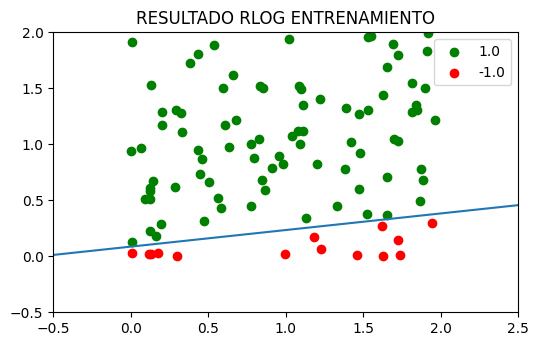

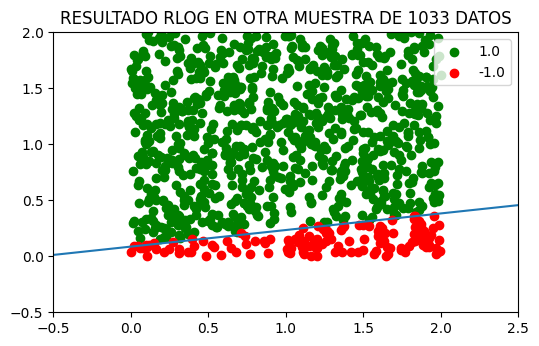

In [57]:
impresion2(x,y,w1,"RESULTADO RLOG ENTRENAMIENTO")
impresion2(x_out,y_out,w1,"RESULTADO RLOG EN OTRA MUESTRA DE 1033 DATOS")

In [58]:
###EXPERIMENTO
np.random.seed(0)
intervalo=[0,2]

#Experimentos a realizar
num_exp = 50

#Variables para calcular al final las medias pedidas
mis_in = 0
mis_out = 0
epoc = 0
ein = 0
eout = 0
ein2 = 0
eout2 = 0

for exp in range(num_exp):
  #Se repite exactamente lo mismo que antes, pero sumando a las variables correspondientes los valores
  #de los cuales se quiere hayar la media
  a,b = simula_recta(intervalo)

  puntos = simula_unif(100,2,intervalo)
  x = puntos.copy()
  x = np.insert(x, 0, 1, axis=1)

  y = []
  for elem in x:
    y.append(f(elem[1], elem[2], a, b))
  y = np.array(y)

  #Con 0.01 no se comportaba bien, convergia en 1
  w1, ep1 = sgdRL(x,y,1,1,200, vini)
  epoc += ep1
  ein += CEE(x,y,w1)
  ein2 += CEE2(x,y,w1)
  mis_in += miss_rate_RL_2(x,y,w1)

  puntos_out = simula_unif(1033,2,intervalo)
  x_out = puntos_out.copy()
  x_out = np.insert(x_out, 0, 1, axis=1)
  # a1,b1 = simula_recta(intervalo)
  y_out = []
  for elem in x_out:
    y_out.append(f(elem[1], elem[2], a, b))
  y_out = np.array(y_out)
  eout += CEE(x_out,y_out,w1)
  eout2 += CEE2(x_out,y_out,w1)
  mis_out += miss_rate_RL_2(x_out,y_out,w1)

print(f"Epocas para converger de media: {epoc/num_exp}")
print(f"Ein medio: {ein/num_exp}")
print(f"Ein prueba medio: {ein2/num_exp}")
print(f"Eout medio: {eout/num_exp}")
print(f"Eout prueba medio: {eout2/num_exp}")
print(f"Mis rate entrenamiento medio: {mis_in/num_exp}")
print(f"Mis rate out medio: {mis_out/num_exp}")

Epocas para converger de media: 200.0
Ein medio: 0.02135155754601749
Ein prueba medio: 0.021351557546017495
Eout medio: 0.03219830240967295
Eout prueba medio: 0.03219830240967297
Mis rate entrenamiento medio: 0.62
Mis rate out medio: 1.2855759922555672


Como se puede observar en los resultados, se ha logrado una buena tasa de acierto. Aunque ajustando más los parámetros se debería lograr una tasa de fallo de 0 de media, ya que los datos son linealmente separables. Los errores que van acompañados de la palabra "prueba", son, como bien indica el nombre, una prueba de la fórmula de Andrew NG para comprobar que devolvía el mismo error que la fórmula que se nos proporcionó en clase de teoría.

<font color='blue'>Ahora repita el mismo experimento, pero empleando datos no linealmente separables. Para ello, debe introducirse un 10% de ruido por clase. 

In [59]:
###EXPERIMENTO
np.random.seed(0)
intervalo=[0,2]

num_exp = 50

mis_in = 0
mis_out = 0
epoc = 0
ein = 0
eout = 0

for exp in range(num_exp):
  #Igual que anteriormente pero la y tiene ruido
  a,b = simula_recta(intervalo)

  puntos = simula_unif(100,2,intervalo)
  x = puntos.copy()
  x = np.insert(x, 0, 1, axis=1)

  y = []
  for elem in x:
    y.append(f(elem[1], elem[2], a, b))
  y = np.array(y)

  y = introducir_ruido(y,10)

  w1, ep1 = sgdRL(x,y,1,1,200, vini)
  epoc += ep1
  ein += CEE(x,y,w1)
  mis_in += miss_rate_RL_2(x,y,w1)

  puntos_out = simula_unif(1033,2,intervalo)
  x_out = puntos_out.copy()
  x_out = np.insert(x_out, 0, 1, axis=1)
  # a1,b1 = simula_recta(intervalo)
  y_out = []
  for elem in x_out:
    y_out.append(f(elem[1], elem[2], a, b))
  y_out = np.array(y_out)
  y_out = introducir_ruido(y_out,10)
  
  eout += CEE(x_out,y_out,w1)
  mis_out += miss_rate_RL_2(x_out,y_out,w1)

print(f"Epocas para converger de media: {epoc/num_exp}")
print(f"Ein medio: {ein/num_exp}")
print(f"Eout medio: {eout/num_exp}")
print(f"Mis rate entrenamiento medio: {mis_in/num_exp}")
print(f"Mis rate out medio: {mis_out/num_exp}")

Epocas para converger de media: 200.0
Ein medio: 0.579891182846653
Eout medio: 0.5991390743321144
Mis rate entrenamiento medio: 20.94
Mis rate out medio: 21.606969990319456


En cuanto a los datos con ruido, es imposible lograr una tasa de fallo de un 0% usando un hiperplano separador. Aún así, se obtiene una tasa de fallo no superior al 22% en ambos casos.

La función de coste que se usa para la expresión de la entropía cruzada es la siguiente:
$f(h(x))= \left\{ \begin{array}{lcc}
             -log(h(x)) &   si  & etiq = 1 \\
             \\ -log(1-h(x)) &  si & etiq = 0
             \end{array}
   \right.$



<ipython-input-60-b94a0f3bbe62>:4: RuntimeWarning: divide by zero encountered in log
  return -np.log(x)
<ipython-input-60-b94a0f3bbe62>:6: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-x)


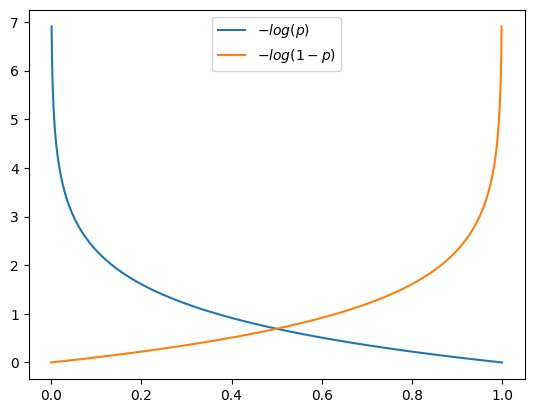

In [60]:
#COMENTARIOS ENTROPÍA CRUZADA
def funcion_coste(x, y):
  if(y==1):
    return -np.log(x)
  if(y==-1):
    return -np.log(1-x)

x = np.linspace(0,1,1000)

y = np.ones(1000)
y_2 = y*-1

vect = np.vectorize(funcion_coste)
plt.plot(x, vect(x,y), label = "$-log(p)$")
plt.plot(x, vect(x,y_2), label = "$-log(1-p)$")
plt.legend()
plt.show()

Esta gráfica ayuda a comprender mucho mejor como funciona el error de entropía cruzada y como un acierto o un fallo aporta valor a este error.

Por ejemplo, si un dato tiene etiqueta 1 y nuestro modelo lo ha predicho con etiqueta 1 con probabilidad 1, esto sumará 0 al error (ver línea azul). Es más, si nuestro modelo lo ha predicho con probabilidad 0.6, a pesar de acertar, también aporta al error. Sin embargo, si nuestro modelo da una probabilidad cercana a 0 para este dato, se sumará al error un valor más alto.

El caso de las etiquetas 0 (para nosotros -1), es igual, pero justo al contrario.

Por tanto, parece lógico pensar, que aunque la regresión logística separe perfectamente todos los datos, el error no tiene por qué ser 0, ya que para ello debería devolver para todos los datos con etiqueta 1 un 1 de probabilidad y para los de -1, un 0 de probabilidad, lo cuál es difícil que ocurra en la práctica.

Antes de finalizar con esta parte, me gustaría comentar algunos problemas y dudas que he tenido y exponer una serie de argumentos para lidiar con ellos.


*   El primero de los problemas ha sido que en clase se comentó la POSIBILIDAD de que había ciertas personas que para que su modelo convergiera necesitaban unos LR muy altos, dada la naturaleza de la entropía cruzada y de la forma y pendiente de su gráfica. No obstante, al ejecutar el experimento aislado que se hace justo antes de los dos experimentos que se piden, si bien es cierto que converge rápido, si se imprime la evolución del error se puede ver que da unos saltos bastante grandes y todo me lleva a pensar de que converge rápidamente por la propia naturaleza de los puntos, es decir, por pura suerte, ya que, en el bonus, si se proporciona a RLOG un LR muy alto, los resultados son malísimos.
Estos son algunos saltos del error para un LR de 1000 1 de tamaño de minibatch y 200 epocas (en una misma época).


> 0.6292683672170017/
0.6292683672170017/
0.6292683672170017/
0.6292683672170017/
inf/
7.603827912010108/
7.603827912010108/
7.603827912010108/
7.603827912010108

> El infinito es por un overflow en la exponencial del error.

* Cierto es también que en el experimento con datos linealmente separables, se logra con el LR a 1000 un 0 de tasa de fallo de media, pero una vez pasamos a la muestra con ruido, los resultados empeoran con respecto al LR a 1. Estos serían los resultados:


> Mis rate entrenamiento medio: 23.36

> Mis rate out medio: 24.137463697967092




> Generalmente, no veo recomendable el uso de LR tan altos, ya que no permiten controlar el comportamiento de la función. Aunque se logre el mínimo de forma rápida, por lo expuesto anteriormente, esto puede ser por un comportamiento puntual del algoritmo.












*   El segundo de los problemas ha sido un comportamiento con LR de 1, que incluso también pasa con LR a 0.1. Es lo siguiente:



> 0.009843181082032899 / 0.009749491892227086 /
0.010192047478933508



> Tras consultarlo con el profesor y entender bien el descenso de gradiente estocástico, tiene sentido que esto pase, ya la función a minimizar se va recorriendo en base a los minibatches, no el conjutno completo. Además, con esos LR, la tendencia es claramente positiva a reducir el error.








---

## <font color='blue'> Bonus (1.5 puntos). Clasificación de dígitos.

El BONUS solo se tendrá en cuenta si se ha obtenido al menos el 75\% de los puntos de la
parte obligatoria.</font>

<font color='blue'>Considerar el conjunto de datos de dígitos manuscritos, y seleccionar las muestras de los dígitos 4 y 8. Extraer las características de intensidad promedio y simetría en la manera que se indicó en la práctica anterior.
</font>

<font color='blue'> 1) Plantear un problema de clasificación binaria que considere el conjunto de entrenamiento
como datos de entrada para aprender la función $g$.

<font color='blue'> 2) Compárense los modelos de regresión lineal, PLA, RL y PLA-Pocket. 

> <font color='blue'> a) Generar gráficos separados de los datos de entrenamiento y test junto con
la función estimada.

> <font color='blue'> b) Calcular $E_{in}$ y $E_{test}$ (error sobre los datos de test).

> <font color='blue'> c) Si se emplean los pesos obtenidos con regresión lineal para inicializar los otros tres métodos (RL, PLA, PLA-pocket), ¿se observa alguna mejora en los resultados a algún nivel? Justifique su respuesta.

> <font color='blue'> d) Obtener cotas sobre el verdadero valor de $E_{out}$ para los cuatro métodos empleados. Calcúlense dos cotas: una
basada en $E_{in}$ y otra basada en $E_{test}$. Usar una tolerancia $\delta = 0.05$. ¿Qué cota es
mejor? Justifique la respuesta.  


En adelante, para el error de RLOG, se usará la entropía cruzada definida más arriba. Para los PLA y para RLIN se usarán, respectivamente, las siguientes métricas:

$E_{in}(w) = \frac{1}{N}\sum_{i=1}^{N}1_{sign(w^Tx_i) \neq y_i}$

$E_{in}(w) = \frac{1}{N}\sum_{n=1}^{N}(w^Tx_n - y_n)^2$

Qué son la tasa de acierto entre el número de datos y el error cuadrático medio.


In [61]:
#Para acceder a nuestros ficheros de Google Drive
from google.colab import drive
drive.mount('/content/drive')
# La carpeta datos (que contiene X_train.npy, y_train.npy, X_test.npy y y_test.npy) 
# debe estar en vuestro Drive, dentro de la carpeta 'Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
# Funcion para leer los datos
def readData(file_x, file_y, class1, class2, label_class1, label_class2):
    # Leemos los ficheros    
    datax = np.load(file_x)
    datay = np.load(file_y)
    y = []
    x = []    
    # Solo guardamos los datos de las dos clases que nos interesan
    for i in range(0,datay.size):
        if datay[i] == class1 or datay[i] == class2:
            if datay[i] == class1:
                y.append(label_class1)
            else:
                y.append(label_class2)
            x.append(np.array([1, datax[i][0], datax[i][1]]))
            
    x = np.array(x, np.float64)
    y = np.array(y, np.float64)
    
    return x, y

In [63]:
class1 = 8 #dígito 8
class2 = 4 #dígito 4
label1 = 1 #etiqueta empleada para representar class1
label2 = -1 #etiqueta empleada para representar class2
# Lectura de los datos de entrenamiento 
x, y = readData('drive/MyDrive/Colab Notebooks/datos/X_train.npy', 
                'drive/MyDrive/Colab Notebooks/datos/y_train.npy', class1, class2, label1, label2)
# Lectura de los datos para el test
x_test, y_test = readData('drive/MyDrive/Colab Notebooks/datos/X_test.npy', 
                          'drive/MyDrive/Colab Notebooks/datos/y_test.npy', class1, class2, label1, label2)

In [64]:
##Aqui vendria funcion de Ein para PLA

##Revisar bien lo del mínimo
def error_pocket2(x, y, w):
  sign = np.vectorize(signo)
  predictions = sign(np.dot(x, w))
  no_clas = y == predictions
  error = np.count_nonzero(no_clas == False)
  return error/len(y)

def error_pocket(x, y, w):
  predictions = np.dot(x, w)
  errors = np.maximum(0, -y * predictions)
  return np.mean(errors)

#PLA POCKET es exactamente análogo a PLA pero cada vez que se actualiza w, se compara con la mejor guardada y si es mejor se actualiza. Se devuelve esta w
#no, la del final de la ejecución.
def ajusta_PLA_pocket(datos, label, max_iter, vini):
    w = vini.copy()
    x = datos.copy()
    y = label.copy()

    pocket = w.copy()
    error_poc = error_pocket2(x,y,w)
    no_cambios = False
    it = 0
    if(max_iter < 0):
      while(no_cambios == False):
        no_cambios = True
        for i in range(len(y)):
          carac = x[i]
          l = y[i]
          
          if (signo(w.T@carac) != l):
            w = w + l * carac
            no_cambios = False
            error_actual = error_pocket2(x,y,w)

          if( error_actual < error_poc):
            pocket = w.copy()
            error_poc = error_actual

          it += 1
    else:
      while(no_cambios == False):
        no_cambios = True
        
        for i in range(len(y)):
          carac = x[i]
          l = y[i]
           
          if (signo(w.T@carac) != l and it < max_iter):
            w = w + l * carac
            no_cambios = False
            error_actual = error_pocket2(x,y,w)
          if(it >= max_iter):
            return pocket, it
          
          
          if( error_actual < error_poc):
            pocket = w.copy()
            error_poc = error_actual

          it += 1
          
          
    return pocket, it

# Algoritmo pseudoinversa    
def pseudoinverse(x, y):
    #Lo primero sera hallar la pseudoinversa de x usando la descomposición en valores singulares  de la matriz
    U, D, V_t = np.linalg.svd(x, full_matrices=True)
    #x_pseudo = np.linalg.pinv(x)
    x_pseudo = np.transpose(V_t) @ np.linalg.inv(np.diag(D))  @ np.linalg.inv(np.diag(D)) @ V_t
    # x_pseudo = np.transpose(V_t) @ np.linalg.inv(np.diag(D) @ np.diag(D))@ np.transpose(np.diag(D)) @ V_t
    x_pseudo = x_pseudo @ np.transpose(x)

    #print(x_pseudo)
    w = np.dot(x_pseudo,y)
    return w

def MSE(x,y,w):
    return (1/y.size)*np.linalg.norm(x.dot(w)-y)**2

In [65]:
def impresion(x,y,w, titulo):
  fig = plt.figure(figsize=(6,8))
  ax1 = fig.add_subplot(211)
  plot1 = x[np.where(y==1)]
  ax1.scatter(plot1[:,1], plot1[:,2], color="green", label = 1.0)
  plot_minus1 = x[np.where(y==-1)]
  ax1.scatter(plot_minus1[:,1], plot_minus1[:,2], color="red", label = -1.0)

  x1 = np.linspace(-60,60,2)
  y1 = ((w[0]+w[1]*x1)/-w[2])
  ax1.plot(x1,y1)
  ax1.set_xlim(0,1)
  ax1.set_ylim(-8,1)
  ax1.set_title(titulo)
  ax1.legend(loc="upper right")

  ####Tengo que poner mi frontera de decisión, igualmente preguntar si uso la sigmoide para el error de clasificación o el signo de distancia a la recta
  plt.show()

TABLA RESULTADOS
+-------------+----------+----------+--------------------+----------------------+
| ALGORITMO   |      EIN |    ETEST |   MIS. RATE (%) IN |   MIS. RATE (%) TEST |
+=============+==========+==========+====================+======================+
| POCKET      | 0.211055 | 0.251366 |            21.1055 |              25.1366 |
+-------------+----------+----------+--------------------+----------------------+
| PLA         | 0.224456 | 0.265027 |            22.4456 |              26.5027 |
+-------------+----------+----------+--------------------+----------------------+
| RLOG        | 1.18867  | 1.51859  |            21.7755 |              24.5902 |
+-------------+----------+----------+--------------------+----------------------+
| RLIN        | 0.642853 | 0.708715 |            22.7806 |              25.1366 |
+-------------+----------+----------+--------------------+----------------------+


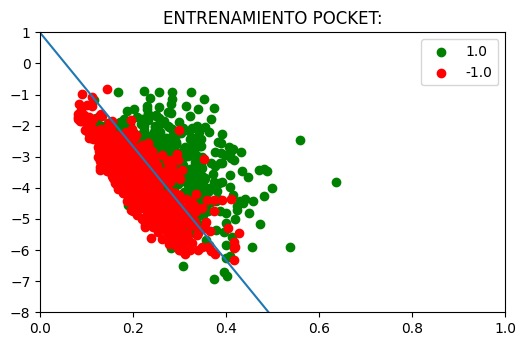

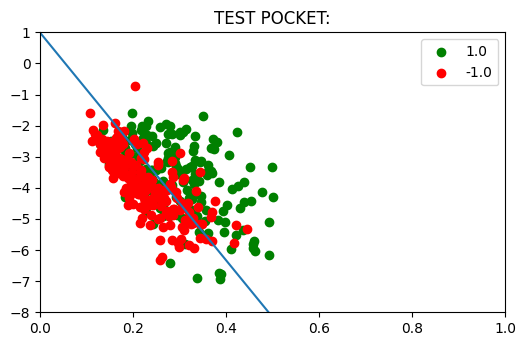

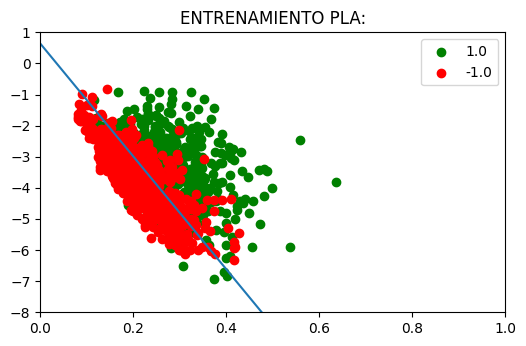

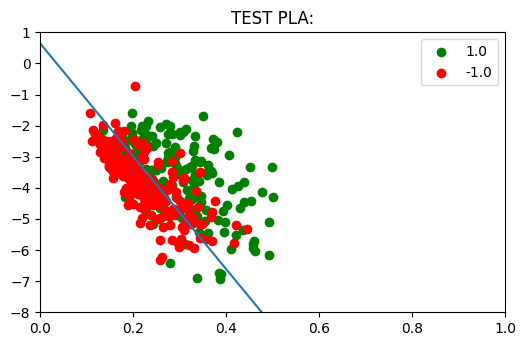

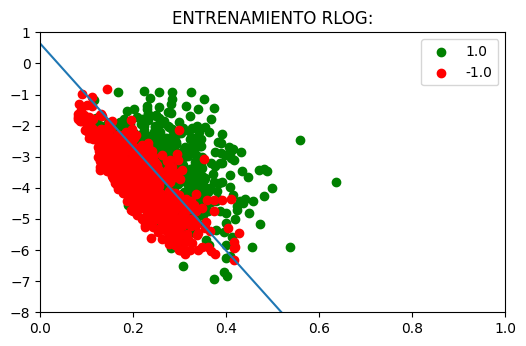

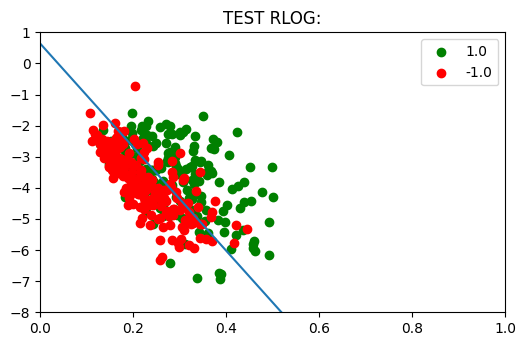

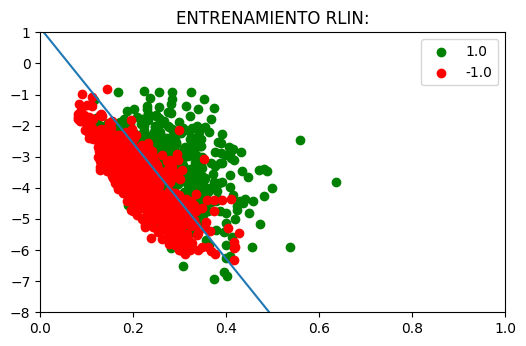

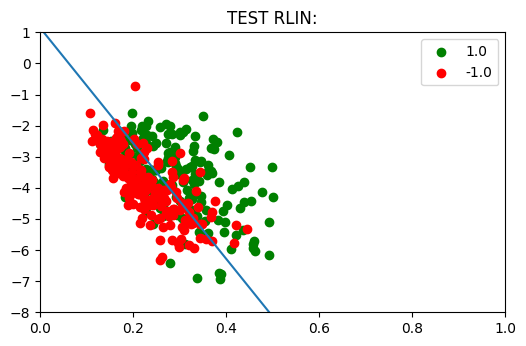

In [66]:
#Variables para usar tabulate
dic_tabla_1 = {}
ws = []
eins =[]
eouts = []
miss_rate_in = []
miss_rate_out = []
orden = ["POCKET", "PLA", "RLOG", "RLIN"]
v_ini = np.zeros(x.shape[1])
###PLA POCKET
w_pla_p, it_pla_p = ajusta_PLA_pocket(x, y, 150000, v_ini)
ws.append(w_pla_p)
eins.append(error_pocket2(x,y,w_pla_p))
eouts.append(error_pocket2(x_test,y_test,w_pla_p))
miss_rate_in.append(miss_rate_RL(x,y,w_pla_p))
miss_rate_out.append(miss_rate_RL(x_test,y_test,w_pla_p))

w_pla, it_pla = ajusta_PLA(x, y, 150000, v_ini)
ws.append(w_pla)
eins.append(error_pocket2(x,y,w_pla))
eouts.append(error_pocket2(x_test,y_test,w_pla))
miss_rate_in.append(miss_rate_RL(x,y,w_pla))
miss_rate_out.append(miss_rate_RL(x_test,y_test,w_pla))
#Mejor con 32 que con 1 de minibatch
w_rl, epoc_rl = sgdRL(x,y,1,1,200, v_ini)
ws.append(w_rl)
eins.append(CEE(x,y,w_rl))
eouts.append(CEE(x_test,y_test,w_rl))
miss_rate_in.append(miss_rate_RL(x,y,w_rl))
miss_rate_out.append(miss_rate_RL(x_test,y_test,w_rl))
#REGRESION LINEAL
w_rli = pseudoinverse(x,y)
ws.append(w_rli)
eins.append(MSE(x,y,w_rli))
eouts.append(MSE(x_test,y_test,w_rli))
miss_rate_in.append(miss_rate_RL(x,y,w_rli))
miss_rate_out.append(miss_rate_RL(x_test,y_test,w_rli))


print("TABLA RESULTADOS")
dic_tabla_1["ALGORITMO"] = orden
dic_tabla_1["EIN"] = eins
dic_tabla_1["ETEST"] = eouts
dic_tabla_1["MIS. RATE (%) IN"] = miss_rate_in
dic_tabla_1["MIS. RATE (%) TEST"] = miss_rate_out

print(tabulate(dic_tabla_1, headers=dic_tabla_1.keys(), tablefmt = "grid"))
# print(f"EIN RL: {CEE(x,y,w_rl)}\nETEST RL: {CEE(x_test,y_test,w_rl)}")
# print(f"EIN RLIN: {MSE(x,y,w_rli)}\nETEST RL: {MSE(x_test,y_test,w_rli)}")
# # w_poc, it_poc = ajusta_PLA_pocket(x, y, 150000, v_ini)
# impresion_bonus(x,y,w_pla, "ENTRENAMIENTO PLA:")
# impresion_bonus(x_test,y_test,w_pla, "TEST PLA:")
# impresion_bonus(x,y,w_rl, "ENTRENAMIENTO RL:")
# impresion_bonus(x_test,y_test,w_rl, "TEST RL:")
impresion(x,y,w_pla_p, "ENTRENAMIENTO POCKET:")
impresion(x_test,y_test,w_pla_p, "TEST POCKET:")
impresion(x,y,w_pla, "ENTRENAMIENTO PLA:")
impresion(x_test,y_test,w_pla, "TEST PLA:")
impresion(x,y,w_rl, "ENTRENAMIENTO RLOG:")
impresion(x_test,y_test,w_rl, "TEST RLOG:")
impresion(x,y,w_rli, "ENTRENAMIENTO RLIN:")
impresion(x_test,y_test,w_rli, "TEST RLIN:")


Tras realizar las ejecuciones con los distintos algoritmos y funciones de pérdida, ha ocurrido lo esperado. Los algoritmos que mejor se comportan son Regresión Logística y PLA-POCKET.

TABLA RESULTADOS
+-------------+----------+----------+--------------------+----------------------+
| ALGORITMO   |      EIN |    ETEST |   MIS. RATE (%) IN |   MIS. RATE (%) TEST |
+=============+==========+==========+====================+======================+
| RLIN        | 0.642853 | 0.708715 |            22.7806 |              25.1366 |
+-------------+----------+----------+--------------------+----------------------+
| POCKET      | 0.210218 | 0.251366 |            21.0218 |              25.1366 |
+-------------+----------+----------+--------------------+----------------------+
| PLA         | 0.329146 | 0.36612  |            32.9146 |              36.612  |
+-------------+----------+----------+--------------------+----------------------+
| RLOG        | 1.0526   | 1.51543  |            22.8643 |              28.6885 |
+-------------+----------+----------+--------------------+----------------------+


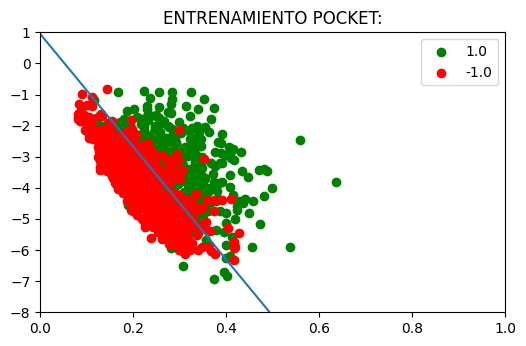

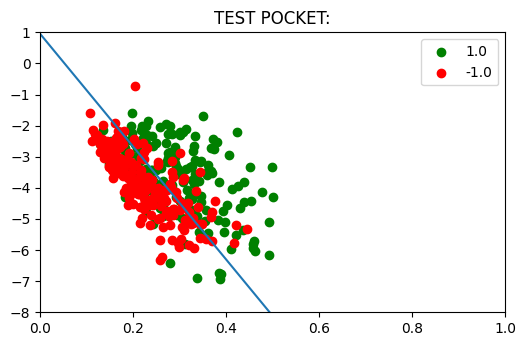

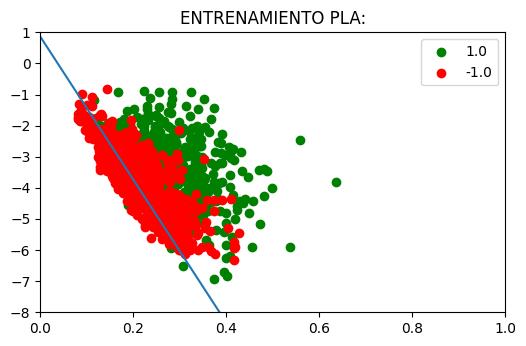

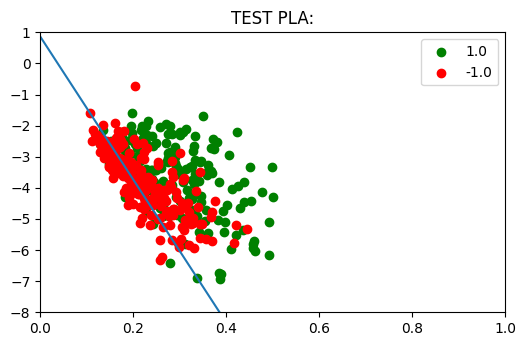

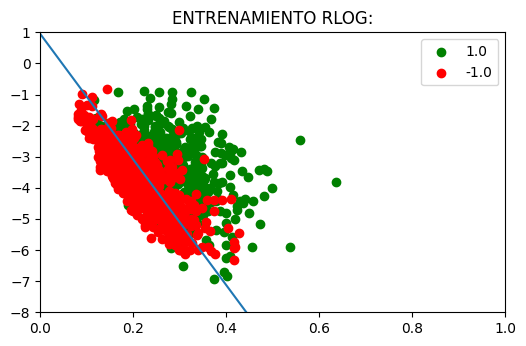

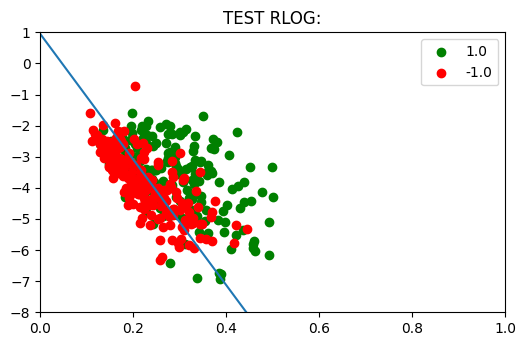

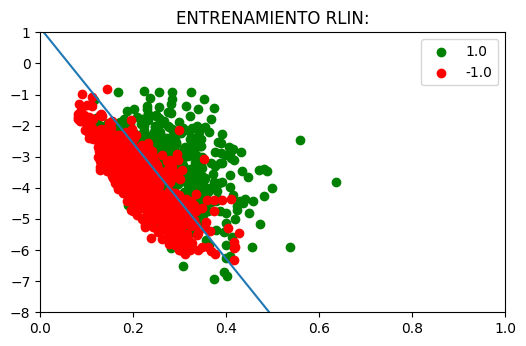

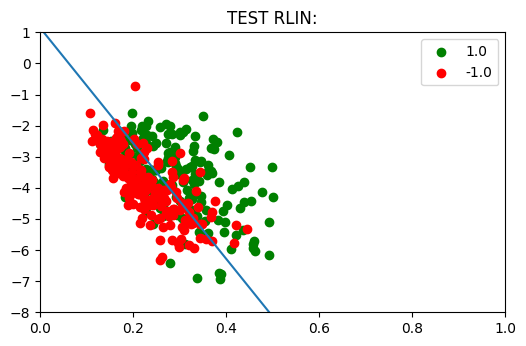

In [67]:
#Variables para usar tabulate
dic_tabla_1 = {}
ws = []
eins =[]
eouts = []
miss_rate_in = []
miss_rate_out = []
orden = ["RLIN","POCKET", "PLA", "RLOG"]

#REGRESION LINEAL
w_rli = pseudoinverse(x,y)
ws.append(w_rli)
eins.append(MSE(x,y,w_rli))
eouts.append(MSE(x_test,y_test,w_rli))
miss_rate_in.append(miss_rate_RL(x,y,w_rli))
miss_rate_out.append(miss_rate_RL(x_test,y_test,w_rli))
v_ini = w_rli.copy()
###PLA POCKET
w_pla_p, it_pla_p = ajusta_PLA_pocket(x, y, 150000, v_ini)
ws.append(w_pla_p)
eins.append(error_pocket2(x,y,w_pla_p))
eouts.append(error_pocket2(x_test,y_test,w_pla_p))
miss_rate_in.append(miss_rate_RL(x,y,w_pla_p))
miss_rate_out.append(miss_rate_RL(x_test,y_test,w_pla_p))


w_pla, it_pla = ajusta_PLA(x, y, 150000, v_ini)
ws.append(w_pla)
eins.append(error_pocket2(x,y,w_pla))
eouts.append(error_pocket2(x_test,y_test,w_pla))
miss_rate_in.append(miss_rate_RL(x,y,w_pla))
miss_rate_out.append(miss_rate_RL(x_test,y_test,w_pla))
#Mejor con 32 que con 1 de minibatch
w_rl, epoc_rl = sgdRL(x,y,1,1,200,v_ini)
ws.append(w_rl)
eins.append(CEE(x,y,w_rl))
eouts.append(CEE(x_test,y_test,w_rl))
miss_rate_in.append(miss_rate_RL(x,y,w_rl))
miss_rate_out.append(miss_rate_RL(x_test,y_test,w_rl))


print("TABLA RESULTADOS")
dic_tabla_1["ALGORITMO"] = orden
dic_tabla_1["EIN"] = eins
dic_tabla_1["ETEST"] = eouts
dic_tabla_1["MIS. RATE (%) IN"] = miss_rate_in
dic_tabla_1["MIS. RATE (%) TEST"] = miss_rate_out
print(tabulate(dic_tabla_1, headers=dic_tabla_1.keys(), tablefmt = "grid"))
# print(f"EIN RL: {CEE(x,y,w_rl)}\nETEST RL: {CEE(x_test,y_test,w_rl)}")
# print(f"EIN RLIN: {MSE(x,y,w_rli)}\nETEST RL: {MSE(x_test,y_test,w_rli)}")
# # w_poc, it_poc = ajusta_PLA_pocket(x, y, 150000, v_ini)
# impresion_bonus(x,y,w_pla, "ENTRENAMIENTO PLA:")
# impresion_bonus(x_test,y_test,w_pla, "TEST PLA:")
# impresion_bonus(x,y,w_rl, "ENTRENAMIENTO RL:")
# impresion_bonus(x_test,y_test,w_rl, "TEST RL:")
impresion(x,y,w_pla_p, "ENTRENAMIENTO POCKET:")
impresion(x_test,y_test,w_pla_p, "TEST POCKET:")
impresion(x,y,w_pla, "ENTRENAMIENTO PLA:")
impresion(x_test,y_test,w_pla, "TEST PLA:")
impresion(x,y,w_rl, "ENTRENAMIENTO RLOG:")
impresion(x_test,y_test,w_rl, "TEST RLOG:")
impresion(x,y,w_rli, "ENTRENAMIENTO RLIN:")
impresion(x_test,y_test,w_rli, "TEST RLIN:")

Ahora tenemos la ejecución partiendo de los pesos proporcionados por Regresión Lineal, que en este caso, al hacer uso del método de la pseudoinversa, son los óptimos para minimizar el error cuadrático medio, pero no se sabe nada acerca de si son los mejores para miniminzar otros tipos de errores. Como se puede observar, en esta ejecución sí que se puede observar una mayor diferencia entre POCKET y PLA. Pero esto se debe a que PLA sin datos linealmente separables, depende en gran medida del número de ejecuciones máximas que se pongan y del punto de inicio. Sin embargo, POCKET obtiene unos resultados parecidos a los de la ejecución anterior. Regresión Logística también se comporta de forma parecida a la ejecución anterior.

Por lo que he expuesto en las primeras líneas de esta explicación, a priori, con la teoría en la mano, no se debería esperar mejora de resultados, ya que los 4 algoritmos son diferentes y regresión lineal nos devuelve los pesos óptimos para minimizar la función de error que usa, la distancia media cuadrada. Nada nos puede hacer pensar que esos pesos también serán los mejores para la entropía cruzada y Perceptron va a modificarlos sí o sí porque los datos no son linealmente separables.

In [68]:
#COTA CON ETEST
def cota_out_test(N, Etest ,delta):
  #La cardinalidad del conjunto de hipótesis en test es !
  return Etest + np.sqrt((1/(2*N))*np.log(2/delta))
def cota_out_in(N, Ein, delta, dvc):
  return Ein + np.sqrt((8/N)*np.log((4*(2*N)**dvc + 1)/delta))
print(f"COTA RLIN MSE")
print(f"Cota RLIN TEST: Eout <= {cota_out_test(len(y_test), MSE(x_test,y_test, w_rli), 0.05)}")
print(f"Cota RLIN EIN: Eout <= {cota_out_in(len(y), MSE(x,y, w_rli), 0.05, 3)}")
print(f"COTA RLIN TASA ACIERTO")
print(f"Cota RLIN TEST: Eout <= {cota_out_test(len(y_test), error_pocket2(x_test,y_test, w_rli), 0.05)}")
print(f"Cota RLIN EIN: Eout <= {cota_out_in(len(y), error_pocket2(x,y, w_rli), 0.05, 3)}")
#añadir error con error pocket
print(f"COTA PLA")
print(f"Cota PLA TEST: Eout <= {cota_out_test(len(y_test), error_pocket2(x_test,y_test, w_pla), 0.05)}")
print(f"Cota PLA EIN: Eout <= {cota_out_in(len(y), error_pocket2(x,y, w_pla), 0.05, 3)}")

print(f"COTA PLA_P")
print(f"Cota PLA_P TEST: Eout <= {cota_out_test(len(y_test), error_pocket2(x_test,y_test, w_pla_p), 0.05)}")
print(f"Cota PLA_P EIN: Eout <= {cota_out_in(len(y), error_pocket2(x,y, w_pla_p), 0.05, 3)}")


print(f"COTA RLOG CROSS ENTROPY")
print(f"Cota RLOG TEST: Eout <= {cota_out_test(len(y_test), CEE(x_test,y_test, w_rl), 0.05)}")
print(f"Cota RLOG EIN: Eout <= {cota_out_in(len(y), CEE(x,y, w_rl), 0.05, 3)}")
print(f"COTA RLOG CROSS TASA ACIERTO")
print(f"Cota RLOG TEST: Eout <= {cota_out_test(len(y_test), error_pocket2(x_test,y_test, w_rl), 0.05)}")
print(f"Cota RLOG EIN: Eout <= {cota_out_in(len(y), error_pocket2(x,y, w_rl), 0.05, 3)}")
#Añadir error con eror pocket

COTA RLIN MSE
Cota RLIN TEST: Eout <= 0.7797039175486132
Cota RLIN EIN: Eout <= 1.0737898018070533
COTA RLIN TASA ACIERTO
Cota RLIN TEST: Eout <= 0.32235522365119473
Cota RLIN EIN: Eout <= 0.6587422006126541
COTA PLA
Cota PLA TEST: Eout <= 0.4371093220118505
Cota PLA EIN: Eout <= 0.7600822341134916
COTA PLA_P
Cota PLA_P TEST: Eout <= 0.32235522365119473
Cota PLA_P EIN: Eout <= 0.6411542609141616
COTA RLOG CROSS ENTROPY
Cota RLOG TEST: Eout <= 1.5864194077964433
Cota RLOG EIN: Eout <= 1.4835322646081424
COTA RLOG CROSS TASA ACIERTO
Cota RLOG TEST: Eout <= 0.3578743493342548
Cota RLOG EIN: Eout <= 0.6595797215506776


En este caso, para regresión lineal y regresión logística, también se ha dado una cota haciendo uso del error usado en PLA. Las funciones de pérdida que usan estos dos algoritmos, son más difíciles de comprender y no nos proporcionan información valiosa sobre como se ha comportado el algoritmo, más allá de ser un soporte teórico para lograr el aprendizaje. Es por ello, que la cota con tasa de fallo es mucho más informativa.


Solo fijándonos en la cota proporcionada para la tasa de fallo, podemos observar que en todos los casos la cota hecha con Etest es mejor que la hecha con Ein, lo cual tiene sentido, ya que estamos dando una cota en base a una hipótesis ya fijada. El conjunto de hipótesis no puede ser más simple, ya que solo cuenta con una.
